<a href="https://colab.research.google.com/github/CrisEsp/Heur-stico/blob/secundario/Heuristico_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import random
import time
import threading
import sys
import threading
from queue import Queue

def redondear_diccionario(d, decimales=2):
    return {k: round(v, decimales) if isinstance(v, (int, float)) else v for k, v in d.items()}

# Variables globales
tipos_produccion_actual = {
    "MC1": None,
    "MC2": None,
    "MC3": None
}

# Variables globales para rastrear alimentaciones y temporizadores
alimentaciones_actuales = set()
alimentaciones_en_progreso = {}
temporizadores_molinos = {}
lock = threading.Lock()
lock_print = threading.Lock()


def nivel_ineficiente_tolva(molino, material):
    if molino == "MC1":
        niveles = niveles_MC1
        tolvas = tolvas_MC1
        return 0.2*tolvas[material]['max_metros']  # 20% de la capacidad
    elif molino == "MC2":
        niveles = niveles_MC2
        tolvas = tolvas_MC2
        return 0.2*tolvas[material]['max_metros']  # 20% de la capacidad
    else:  # MC3
        niveles = niveles_MC3
        tolvas = tolvas_MC3
        return 0.5*tolvas[material]['max_porcentaje'] # 50% de la capacidad

# Cola global para materiales pendientes de alimentación
cola_alimentacion = Queue()

# Definición de capacidades de tolvas y niveles iniciales
tolvas_MC1 = {
    "Clinker": {"capacidad": 500, "max_metros": 14},
    "Puzolana": {"capacidad": 300, "max_metros": 12},
    "Yeso": {"capacidad": 300, "max_metros": 10}
}
tolvas_MC2 = {
    "Clinker": {"capacidad": 300, "max_metros": 9},
    "Puzolana_Humeda": {"capacidad": 500, "max_metros": 15, "tolva": "426HO04"},
    "Puzolana_Seca": {"capacidad": 100, "max_metros": 12, "tolva": "426HO02"},
    "Yeso": {"capacidad": 120, "max_metros": 9}
}
tolvas_MC3 = {
    "Clinker": {"capacidad": 60, "max_porcentaje": 100},
    "Clinker_Silo_Blanco": {"capacidad": 500, "max_porcentaje": 10.5},   #AQUI ES EN MTROS
    "Puzolana": {"capacidad": 35, "max_porcentaje": 100},
    "Yeso": {"capacidad": 30, "max_porcentaje": 100}
}

niveles_MC1 = {"Clinker": 1, "Puzolana": 1, "Yeso": 0.1}
niveles_MC2 = {"Clinker": 1, "Puzolana_Humeda": 0.1, "Puzolana_Seca": 1, "Yeso": 0.2}
niveles_MC3 = {"Clinker": 40, "Clinker_Silo_Blanco": 7, "Puzolana": 60, "Yeso": 48}


# Función para convertir de metros a toneladas
def metros_a_toneladas(niveles, tolvas):
    toneladas = {}
    for material, metros in niveles.items():
        # Verificamos si usamos metros o porcentaje
        if "max_metros" in tolvas[material]:
            capacidad = tolvas[material]["capacidad"]
            max_metros = tolvas[material]["max_metros"]
            toneladas[material] = round((metros * capacidad) / max_metros, 2)
        elif "max_porcentaje" in tolvas[material]:
            capacidad = tolvas[material]["capacidad"]
            toneladas[material] = round((metros * capacidad) / 100, 2)
    return toneladas


# Convertimos los niveles de metros a toneladas
niveles_MC1_toneladas = metros_a_toneladas(niveles_MC1, tolvas_MC1)
niveles_MC2_toneladas = metros_a_toneladas(niveles_MC2, tolvas_MC2)
niveles_MC3_toneladas = metros_a_toneladas(niveles_MC3, tolvas_MC3)

# Imprimir los resultados en el mismo formato solicitado
print(f"niveles_MC1_toneladas = {niveles_MC1_toneladas}")
print(f"niveles_MC2_toneladas = {niveles_MC2_toneladas}")
print(f"niveles_MC3_toneladas = {niveles_MC3_toneladas}")


# Diccionario con el estado de los molinos
estado_molinos = {
    "MC1": False,  # True = en marcha, False = detenido
    "MC2": False,
    "MC3": True
}

def verificar_estado_molino(molino):
    """
    Función que verifica si un molino está en marcha o detenido.
    Devuelve True si el molino está en marcha, False si está detenido.
    """
    if molino in estado_molinos:
        return estado_molinos[molino]
    else:
        print(f"Error: Estado desconocido para el molino {molino}")
        return False



# # Funciones auxiliares
# def calcular_tiempo_vaciado(molino, material):
#     if molino == "MC1":
#         niveles = niveles_MC1
#         tolvas = tolvas_MC1
#         capacidad = tolvas[material]['capacidad']
#         print(f"Capacidad de {material}: {capacidad}t")
#         nivel_actual = niveles[material]
#         print(f"Nivel actual de {material}: {nivel_actual}t")
#         nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
#         print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}t")

#     elif molino == "MC2":
#         niveles = niveles_MC2
#         tolvas = tolvas_MC2
#         capacidad = tolvas[material]['capacidad']
#         print(f"Capacidad de {material}: {capacidad}t")
#         nivel_actual = niveles[material]
#         print(f"Nivel actual de {material}: {nivel_actual}t")
#         nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
#         print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}t")

#     else:  # MC3
#         niveles = niveles_MC3
#         tolvas = tolvas_MC3
#         capacidad = tolvas[material]['capacidad']
#         print(f"Capacidad de {material}: {capacidad}t")
#         nivel_actual = niveles[material]
#         print(f"Nivel actual de {material}: {nivel_actual}%")
#         nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
#         print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}%")

#     if 'max_metros' in tolvas[material]:
#         max_nivel = tolvas[material]['max_metros']
#         toneladas_reales = ((nivel_actual - nivel_ineficiente) * capacidad) / max_nivel
#         # print("nivel actual", nivel_actual)
#         # print("nivel ineficiente",nivel_ineficiente)
#         # print("capacidad",capacidad)
#         # print("max nivel",max_nivel)
#         # print("toneladas reales",toneladas_reales)
#     else:  # Para MC3 que usa porcentajes
#         toneladas_reales = ((nivel_actual - nivel_ineficiente) * capacidad) /100
#         #print("toneladas reales",toneladas_reales)
#     consumo = calcular_consumo(molino, material)
#     print(f"Consumo de {material}: {consumo}t/h")

#     if consumo > 0:
#         return toneladas_reales / consumo
#     else:
#         return float('inf')
#############################################################




def obtener_tipo_produccion_actual(molino):
    """    Retorna el tipo de producción actual para un molino específico basado en lo que el usuario haya ingresado.
    """
    return tipos_produccion_actual.get(molino, None)  # Retorna el tipo de producción si está presente, o None si no se ha ingresado

def calcular_consumo(molino, material):
    tipo_produccion = obtener_tipo_produccion_actual(molino)
    necesidades = calcular_necesidades(molino, tipo_produccion)
    return necesidades.get(material, 0)

def calcular_necesidades(molino, tipo_produccion):
    produccion_MC1 = {
        "P30": (0.30, 0.015, 75),
        "P40": (0.40, 0.015, 65)
    }
    produccion_MC2 = {
        "P10": (0.10, 0.03, 65),
        "P16": (0.16, 0.025, 80),
        "P20": (0.12, 0.025, 90),
        "P30": (0.30, 0.02, 110)
    }
    produccion_MC3 = {
        "P30": (0.30, 0.025, 36)
    }


    if molino == "MC1" and tipo_produccion in produccion_MC1:
        puzolana, yeso, produccion = produccion_MC1[tipo_produccion]
        clinker = 1 - puzolana - yeso
        return {
            "Clinker": clinker * produccion,
            "Puzolana": puzolana * produccion,
            "Yeso": yeso * produccion
        }
    elif molino == "MC2" and tipo_produccion in produccion_MC2:
        puzolana, yeso, produccion = produccion_MC2[tipo_produccion]
        clinker = 1 - puzolana - yeso
        return {
            "Clinker": clinker * produccion,
            "Puzolana_Humeda": puzolana * produccion ,
            "Puzolana_Seca": puzolana * produccion ,
            "Yeso": yeso * produccion
        }
    elif molino == "MC3" and tipo_produccion in produccion_MC3:
        puzolana, yeso, produccion = produccion_MC3[tipo_produccion]
        clinker = 1 - puzolana - yeso
        return {
            "Clinker": clinker * produccion,
            "Puzolana": puzolana * produccion,
            "Clinker_Silo_Blanco":clinker*produccion,
            "Yeso": yeso * produccion
        }

    print(f"Advertencia: No se encontró configuración para {molino} con producto {tipo_produccion}")
    return {"Clinker": 60, "Puzolana": 30, "Yeso": 10}



# Función de cálculo de tiempo de vaciado
def calcular_tiempo_vaciado(molino, material):
    # Verificamos si el molino está en marcha
    if not verificar_estado_molino(molino):
        print(f"El molino {molino} está detenido. No se realizarán cálculos para este molino.")
        return None

    # Continuamos con los cálculos solo para los molinos en marcha
    if molino == "MC1":
        niveles = niveles_MC1
        tolvas = tolvas_MC1
        capacidad = tolvas[material]['capacidad']
        print(f"Capacidad de {material}: {capacidad}t")
        nivel_actual = niveles[material]
        print(f"Nivel actual de {material}: {nivel_actual}t")
        nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
        print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}t")

    elif molino == "MC2":
        niveles = niveles_MC2
        tolvas = tolvas_MC2
        capacidad = tolvas[material]['capacidad']
        print(f"Capacidad de {material}: {capacidad}t")
        nivel_actual = niveles[material]
        print(f"Nivel actual de {material}: {nivel_actual}t")
        nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
        print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}t")

    elif molino == "MC3":
        niveles = niveles_MC3
        tolvas = tolvas_MC3
        capacidad = tolvas[material]['capacidad']
        print(f"Capacidad de {material}: {capacidad}t")
        nivel_actual = niveles[material]
        print(f"Nivel actual de {material}: {nivel_actual}%")
        nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
        print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}%")

    else:
        print(f"Molino {molino} no reconocido.")
        return None

    if 'max_metros' in tolvas[material]:
        max_nivel = tolvas[material]['max_metros']
        toneladas_reales = ((nivel_actual - nivel_ineficiente) * capacidad) / max_nivel
    else:  # Para MC3 que usa porcentajes
        toneladas_reales = ((nivel_actual - nivel_ineficiente) * capacidad) / 100

    consumo = calcular_consumo(molino, material)
    print(f"Consumo de {material}: {consumo}t/h")

    if consumo > 0:
        return toneladas_reales / consumo
    else:
        return float('inf')

# Llamada para cada molino
material = "Clinker"  # Material de ejemplo
for molino in ["MC1", "MC2", "MC3"]:
    tiempo_vaciado = calcular_tiempo_vaciado(molino, material)
    if tiempo_vaciado is not None:
        print(f"Tiempo de vaciado para {molino}: {tiempo_vaciado} horas.")





# def nivel_silo_blanco():
#     return ((niveles_MC3["Clinker_Silo_Blanco"] - tolvas_MC3["Clinker_Silo_Blanco"]["max_metros"]*0.2)* tolvas_MC3["Clinker_Silo_Blanco"]["capacidad"]) / tolvas_MC3["Clinker_Silo_Blanco"]["max_metros"]
#     print("nivel_silo_blanco",nivel_silo_blanco())

def nivel_426HO04():
    return ((niveles_MC2["Puzolana_Humeda"] - tolvas_MC2["Puzolana_Humeda"]["max_metros"]*0.2)*tolvas_MC2["Puzolana_Humeda"]["capacidad"]) / tolvas_MC2["Puzolana_Humeda"]["max_metros"]

def nivel_puzolana_humeda():
    return ((niveles_MC2["Puzolana_Humeda"] - tolvas_MC2["Puzolana_Humeda"]["max_metros"]*0.2)*tolvas_MC2["Puzolana_Humeda"]["capacidad"]) / tolvas_MC2["Puzolana_Humeda"]["max_metros"]

def se_alimenta_puzolana_a_L1():
    return ("MC1", "Puzolana") in alimentaciones_actuales

def se_alimenta_yeso_a_L1():
    return ("MC1", "Yeso") in alimentaciones_actuales

def se_desea_producir_P10():
    return obtener_tipo_produccion_actual("MC2") == "P10"

def hay_clinker_disponible_en_galpon():
    # Esta función debería verificar si hay clinker disponible en el galpón
    # Por ahora, retornamos un valor aleatorio
    return random.choice([True, False])

def se_alimenta_yeso_a_L1_por_L1():
    return ("MC1", "Yeso") in alimentaciones_actuales and alimentaciones_en_progreso.get("MC1", set()).intersection({"Yeso"})

def se_alimenta_clinker_a_L3():
    return ("MC3", "Clinker") in alimentaciones_actuales

def se_puede_alimentar_L1_por_L2():
    return not any(alim[0] == "MC2" for alim in alimentaciones_actuales)

def se_requiere_alimentar_L2(niveles_MC2):
    # Definir materiales críticos que se requieren para alimentar L2
    materiales_criticos = ['clinker', 'yeso', 'puzolana']

    # Revisar si algún material crítico tiene un nivel bajo
    if any(niveles_MC2[material] < 10 for material in materiales_criticos if material in niveles_MC2):
        print("Se requiere alimentar L2 debido a niveles bajos de materiales.")
        return True

    # Comprobar si se está produciendo un producto que requiere alimentación en L2
    if se_desea_producir_P10():  # Asumiendo que esta función ya está definida
        print("Se requiere alimentar L2 porque se desea producir P10.")
        return True

    # Si ninguna de las condiciones anteriores se cumple
    print("No se requiere alimentar L2 en este momento.")
    return False

def se_alimenta_yeso_a_L2_por_L2():
    return ("MC2", "Yeso") in alimentaciones_actuales

def se_alimenta_yeso_a_L3():
    return ("MC3", "Yeso") in alimentaciones_actuales

def se_alimenta_yeso_a_L3_por_L2():
    return ("MC3", "Yeso") in alimentaciones_actuales and ("MC2", "Yeso") in alimentaciones_actuales

def se_alimenta_yeso_a_L1_por_L2():
    return ("MC1", "Yeso") in alimentaciones_actuales and ("MC2", "Yeso") in alimentaciones_actuales

def se_alimenta_puzolana_a_L1_por_L2():
    return ("MC1", "Puzolana") in alimentaciones_actuales and ("MC2", "Puzolana_Humeda") in alimentaciones_actuales

def se_alimenta_PH_a_426HO04_por_L2():
    return ("MC2", "Puzolana_Humeda") in alimentaciones_actuales


def seleccionar_ruta_alimentacion(molino, material):
    if material == "Clinker":
        return seleccionar_ruta_clinker(molino)
    elif material in ["Puzolana", "Puzolana_Humeda", "Puzolana_Seca"]:
        return seleccionar_ruta_puzolana(molino, material)
    elif material == "Yeso":
        return seleccionar_ruta_yeso(molino)
    else:
        return "Material no reconocido"

# def seleccionar_ruta_clinker(molino):
#     print(f"\n--- Seleccionando ruta de Clinker para {molino} ---")

#     tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Clinker")
#     print("Tv L1 CL",tiempo_vaciado_L1)
#     tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Clinker")
#     print("Tv L2 CL",tiempo_vaciado_L2)
#     tiempo_vaciado_L3 = calcular_tiempo_vaciado("MC3", "Clinker")
#     print("Tv L3 CL",tiempo_vaciado_L3)

#     print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1:.2f}h, L2={tiempo_vaciado_L2:.2f}h, L3={tiempo_vaciado_L3:.2f}h")

#     if tiempo_vaciado_L1 > tiempo_vaciado_L2:
#         print("L1 tiene el mayor tiempo de vaciado que L2")
#         if tiempo_vaciado_L2 > tiempo_vaciado_L3:
#             print("L2 tiene el mayor tiempo de vaciado que L3")
#             #nivel_actual = nivel_silo_blanco()
#             nivel_actual_silo_blanco = niveles_MC3["Clinker_Silo_Blanco"]
#             if nivel_actual_silo_blanco > 3:
#                 print("Nivel del Silo Blanco > 3m, Alimentar Clinker a L3 desde Silo blanco")
#                 print(f"Nivel actual del Silo Blanco: {nivel_actual_silo_blanco:.2f}m")
#                 return "Hacia MC3 desde Silo blanco"
#             else:
#                 return "Alimentar Clinker a Silo Blanco"
#             return "Hacia MC1 desde Pretrit"
#         else:
#             print("Alimentar Clinker a L2 desde pretrituración")
#     elif not tiempo_vaciado_L1 > tiempo_vaciado_L2:
#         if tiempo_vaciado_L1 > tiempo_vaciado_L3:
#             print("L1 tiene mayor tiempo de vaciado que L3")
#             #nivel_actual = nivel_silo_blanco()
#             nivel_actual_silo_blanco = niveles_MC3["Clinker_Silo_Blanco"]
#             print(f"Nivel actual del Silo Blanco: {nivel_actual_silo_blanco:.2f}m")
#             if nivel_actual_silo_blanco > 3:
#                 print("Nivel del Silo Blanco > 3m, Alimentar Clinker a L3 desde Silo blanco")
#                 print("Hacia MC3 desde Silo blanco")
#                 return "Hacia MC2 desde pretrit"
#             else:
#                 print("Nivel del Silo Blanco < 3m, Alimentar Clinker a Silo blanco")
#                 return "Clinker hacia Silo blanco"
#         else:
#             nivel_actual_silo_blanco = niveles_MC3["Clinker_Silo_Blanco"]
#             print(f"Nivel actual del Silo Blanco: {nivel_actual_silo_blanco:.2f}m")
#             if se_requiere_alimentar_L2(niveles_MC2):
#                 print("L2 tiene mayor tiempo de vaciado que L3")
#                 return "Hacia MC2 desde pretrit"
#             elif nivel_actual_silo_blanco > 3:
#                 print("Nivel del Silo Blanco > 3m, Alimentar Clinker a L3 desde Silo blanco")
#                 return "Hacia MC3 desde Silo blanco"
#             else:
#                 return "Hacia MC1 desde Pretrit"

#     print("No se encontró una ruta válida para alimentar Clinker")
#     return "No se puede alimentar Clinker en este momento"


# def seleccionar_ruta_clinker(molino):
#     print(f"\n--- Seleccionando ruta de Clinker para {molino} ---")

#     tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Clinker")
#     tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Clinker")
#     tiempo_vaciado_L3 = calcular_tiempo_vaciado("MC3", "Clinker")

#     print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1:.2f}h, L2={tiempo_vaciado_L2:.2f}h, L3={tiempo_vaciado_L3:.2f}h")

#     nivel_actual_silo_blanco = niveles_MC3["Clinker_Silo_Blanco"]
#     print(f"Nivel actual del Silo Blanco: {nivel_actual_silo_blanco:.2f}m")

#     # Manejo de tiempos de vaciado negativos
#     if tiempo_vaciado_L1 < 0:
#         print("Advertencia: Tiempo de vaciado L1 es negativo, posiblemente el silo está vacío")
#     if tiempo_vaciado_L2 < 0:
#         print("Advertencia: Tiempo de vaciado L2 es negativo, posiblemente el silo está vacío")
#     if tiempo_vaciado_L3 < 0:
#         print("Advertencia: Tiempo de vaciado L3 es negativo, posiblemente el silo está vacío")

#     # Si el molino objetivo es MC1
#     if molino == "MC1":
#         # Si el tiempo de vaciado es negativo o bajo, intentar alimentar desde pretrit o silo blanco
#         if tiempo_vaciado_L1 < 0:
#             print("Forzar alimentación a MC1 desde pretrit o recargar Clinker")
#             return "Forzar alimentación a MC1 desde pretrit"
#         else:
#             # Evaluar si MC1 debe ser alimentado desde pretrit
#             if tiempo_vaciado_L1 > max(tiempo_vaciado_L2, tiempo_vaciado_L3):
#                 print("MC1 tiene el mayor tiempo de vaciado, alimentar desde pretrit")
#                 return "Hacia MC1 desde pretrit"
#             else:
#                 print("Alimentar a MC1, pero hay otras prioridades")

#     # Si el molino objetivo es MC2
#     elif molino == "MC2":
#         if tiempo_vaciado_L2 < 0:
#             print("Forzar alimentación a MC2 desde pretrit o recargar Clinker")
#             return "Forzar alimentación a MC2 desde pretrit"
#         else:
#             if tiempo_vaciado_L2 > max(tiempo_vaciado_L1, tiempo_vaciado_L3):
#                 print("MC2 tiene el mayor tiempo de vaciado, alimentar desde pretrit")
#                 return "Hacia MC2 desde pretrit"
#             else:
#                 print("Alimentar a MC2, pero hay otras prioridades")

#     # Si el molino objetivo es MC3
#     elif molino == "MC3":
#         if tiempo_vaciado_L3 < 0:
#             print("Forzar alimentación a MC3 desde pretrit o recargar Clinker")
#             return "Forzar alimentación a MC3 desde pretrit"
#         else:
#             # Evaluar si MC3 debe ser alimentado desde el silo blanco
#             if tiempo_vaciado_L3 > max(tiempo_vaciado_L1, tiempo_vaciado_L2):
#                 if nivel_actual_silo_blanco > 3:
#                     print("MC3 tiene el mayor tiempo de vaciado, alimentar desde silo blanco")
#                     return "Hacia MC3 desde Silo blanco"
#                 else:
#                     print("MC3 tiene el mayor tiempo de vaciado, pero el silo blanco está bajo, alimentar hacia el silo blanco")
#                     return "Alimentar Clinker a Silo Blanco"
#             else:
#                 print("Alimentar a MC3, pero hay otras prioridades")

#     print("No se encontró una ruta válida para alimentar Clinker")
#     return "No se puede alimentar Clinker en este momento"





# def seleccionar_ruta_clinker(molino):
#     print(f"\n--- Seleccionando ruta de Clinker para {molino} ---")

#     # Verificar si el molino está en marcha
#     if not verificar_estado_molino(molino):
#         print(f"El molino {molino} está detenido, no se puede alimentar Clinker.")
#         return f"El molino {molino} está detenido"

#     tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Clinker")
#     tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Clinker")
#     tiempo_vaciado_L3 = calcular_tiempo_vaciado("MC3", "Clinker")

#     # Verifica si los tiempos son None y ajusta el mensaje
#     tiempo_vaciado_L1_str = f"{tiempo_vaciado_L1:.2f}h" if tiempo_vaciado_L1 is not None else "Molino apagado"
#     tiempo_vaciado_L2_str = f"{tiempo_vaciado_L2:.2f}h" if tiempo_vaciado_L2 is not None else "Molino apagado"
#     tiempo_vaciado_L3_str = f"{tiempo_vaciado_L3:.2f}h" if tiempo_vaciado_L3 is not None else "Molino apagado"

#     # Imprime los tiempos de vaciado
#     print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1_str}, L2={tiempo_vaciado_L2_str}, L3={tiempo_vaciado_L3_str}")


#     nivel_actual_silo_blanco = niveles_MC3["Clinker_Silo_Blanco"]
#     print(f"Nivel actual del Silo Blanco: {nivel_actual_silo_blanco:.2f}m")

#     # Manejo de tiempos de vaciado negativos (verificación en las variables numéricas, no en las cadenas)
#     if tiempo_vaciado_L1 is not None and tiempo_vaciado_L1 < 0:
#         print("Advertencia: Tiempo de vaciado L1 es negativo, posiblemente el silo está vacío")
#     if tiempo_vaciado_L2 is not None and tiempo_vaciado_L2 < 0:
#         print("Advertencia: Tiempo de vaciado L2 es negativo, posiblemente el silo está vacío")
#     if tiempo_vaciado_L3 is not None and tiempo_vaciado_L3 < 0:
#         print("Advertencia: Tiempo de vaciado L3 es negativo, posiblemente el silo está vacío")

#     # Si el molino objetivo es MC1
#     if molino == "MC1":
#         # Si el tiempo de vaciado es negativo o bajo, intentar alimentar desde pretrit o silo blanco
#         if tiempo_vaciado_L1 < 0:
#             print("Forzar alimentación a MC1 desde pretrit o recargar Clinker")
#             return "Forzar alimentación a MC1 desde pretrit"
#         else:
#             # Evaluar si MC1 debe ser alimentado desde pretrit
#             if tiempo_vaciado_L1 > max(tiempo_vaciado_L2, tiempo_vaciado_L3):
#                 print("MC1 tiene el mayor tiempo de vaciado, alimentar desde pretrit")
#                 return "Hacia MC1 desde pretrit"
#             else:
#                 print("Alimentar a MC1, pero hay otras prioridades")

#     # Si el molino objetivo es MC2
#     elif molino == "MC2":
#         if tiempo_vaciado_L2 < 0:
#             print("Forzar alimentación a MC2 desde pretrit o recargar Clinker")
#             return "Forzar alimentación a MC2 desde pretrit"
#         else:
#             if tiempo_vaciado_L2 > max(tiempo_vaciado_L1, tiempo_vaciado_L3):
#                 print("MC2 tiene el mayor tiempo de vaciado, alimentar desde pretrit")
#                 return "Hacia MC2 desde pretrit"
#             else:
#                 print("Alimentar a MC2, pero hay otras prioridades")

#     # Si el molino objetivo es MC3
#     elif molino == "MC3":
#         if tiempo_vaciado_L3 < 0:
#             print("Forzar alimentación a MC3 desde pretrit o recargar Clinker")
#             return "Forzar alimentación a MC3 desde pretrit"
#         else:
#             # Evaluar si MC3 debe ser alimentado desde el silo blanco
#             if tiempo_vaciado_L3 > max(tiempo_vaciado_L1, tiempo_vaciado_L2):
#                 if nivel_actual_silo_blanco > 3:
#                     print("MC3 tiene el mayor tiempo de vaciado, alimentar desde silo blanco")
#                     return "Hacia MC3 desde Silo blanco"
#                 else:
#                     print("MC3 tiene el mayor tiempo de vaciado, pero el silo blanco está bajo, alimentar hacia el silo blanco")
#                     return "Alimentar Clinker a Silo Blanco"
#             else:
#                 print("Alimentar a MC3, pero hay otras prioridades")

#     print("No se encontró una ruta válida para alimentar Clinker")
#     return "No se puede alimentar Clinker en este momento"

def seleccionar_ruta_clinker(molino):
    print(f"\n--- Seleccionando ruta de Clinker para {molino} ---")

    # Verificar si el molino está en marcha, pero las rutas de alimentación se mantienen disponibles
    if not verificar_estado_molino(molino):
        print(f"El molino {molino} está detenido, pero las rutas de alimentación están disponibles.")
        return f"El molino {molino} está detenido"

    # Calcular tiempos de vaciado solo para molinos que están en marcha
    tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Clinker") if verificar_estado_molino("MC1") else None
    tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Clinker") if verificar_estado_molino("MC2") else None
    tiempo_vaciado_L3 = calcular_tiempo_vaciado("MC3", "Clinker") if verificar_estado_molino("MC3") else None

    # Verifica si los tiempos son None y ajusta el mensaje
    tiempo_vaciado_L1_str = f"{tiempo_vaciado_L1:.2f}h" if tiempo_vaciado_L1 is not None else "Molino apagado"
    tiempo_vaciado_L2_str = f"{tiempo_vaciado_L2:.2f}h" if tiempo_vaciado_L2 is not None else "Molino apagado"
    tiempo_vaciado_L3_str = f"{tiempo_vaciado_L3:.2f}h" if tiempo_vaciado_L3 is not None else "Molino apagado"

    # Imprime los tiempos de vaciado
    print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1_str}, L2={tiempo_vaciado_L2_str}, L3={tiempo_vaciado_L3_str}")

    nivel_actual_silo_blanco = niveles_MC3["Clinker_Silo_Blanco"]
    print(f"Nivel actual del Silo Blanco: {nivel_actual_silo_blanco:.2f}m")

    # Manejo de tiempos de vaciado negativos (verificación en las variables numéricas, no en las cadenas)
    if tiempo_vaciado_L1 is not None and tiempo_vaciado_L1 < 0:
        print("Advertencia: Tiempo de vaciado L1 es negativo, posiblemente el silo está vacío")
    if tiempo_vaciado_L2 is not None and tiempo_vaciado_L2 < 0:
        print("Advertencia: Tiempo de vaciado L2 es negativo, posiblemente el silo está vacío")
    if tiempo_vaciado_L3 is not None and tiempo_vaciado_L3 < 0:
        print("Advertencia: Tiempo de vaciado L3 es negativo, posiblemente el silo está vacío")

    # Si el molino objetivo es MC1
    if molino == "MC1":
        if tiempo_vaciado_L1 is None or tiempo_vaciado_L1 < 0:
            print("Forzar alimentación a MC1 desde pretrit o recargar Clinker")
            return "Forzar alimentación a MC1 desde pretrit"
        else:
            if tiempo_vaciado_L1 > max(tiempo_vaciado_L2 or -1, tiempo_vaciado_L3 or -1):
                print("MC1 tiene el mayor tiempo de vaciado, alimentar desde pretrit")
                return "Hacia MC1 desde pretrit"
            else:
                print("Alimentar a MC1, pero hay otras prioridades")

    # Si el molino objetivo es MC2
    elif molino == "MC2":
        if tiempo_vaciado_L2 is None or tiempo_vaciado_L2 < 0:
            print("Forzar alimentación a MC2 desde pretrit o recargar Clinker")
            return "Forzar alimentación a MC2 desde pretrit"
        else:
            if tiempo_vaciado_L2 > max(tiempo_vaciado_L1 or -1, tiempo_vaciado_L3 or -1):
                print("MC2 tiene el mayor tiempo de vaciado, alimentar desde pretrit")
                return "Hacia MC2 desde pretrit"
            else:
                print("Alimentar a MC2, pero hay otras prioridades")

    # Si el molino objetivo es MC3
    elif molino == "MC3":
        if tiempo_vaciado_L3 is None or tiempo_vaciado_L3 < 0:
            print("Forzar alimentación a MC3 desde pretrit o recargar Clinker")
            return "Forzar alimentación a MC3 desde pretrit"
        else:
            if tiempo_vaciado_L3 > max(tiempo_vaciado_L1 or -1, tiempo_vaciado_L2 or -1):
                if nivel_actual_silo_blanco > 3:
                    print("MC3 tiene el mayor tiempo de vaciado, alimentar desde silo blanco")
                    return "Hacia MC3 desde Silo blanco"
                else:
                    print("MC3 tiene el mayor tiempo de vaciado, pero el silo blanco está bajo, alimentar hacia el silo blanco")
                    return "Alimentar Clinker a Silo Blanco"
            else:
                print("Alimentar a MC3, pero hay otras prioridades")

    print("No se encontró una ruta válida para alimentar Clinker")
    return "No se puede alimentar Clinker en este momento"





# def seleccionar_ruta_puzolana(molino, tipo_puzolana):
#     if tipo_puzolana in ["Puzolana", "Puzolana_Humeda"]:
#         tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Puzolana")
#         tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Humeda")

#                 # Verifica si los tiempos son None y ajusta el mensaje
#         tiempo_vaciado_L1_str = f"{tiempo_vaciado_L1:.2f}h" if tiempo_vaciado_L1 is not None else "Molino apagado"
#         tiempo_vaciado_L2_str = f"{tiempo_vaciado_L2:.2f}h" if tiempo_vaciado_L2 is not None else "Molino apagado"
#         #tiempo_vaciado_L3_str = f"{tiempo_vaciado_L3:.2f}h" if tiempo_vaciado_L3 is not None else "Molino apagado"

#         # Imprime los tiempos de vaciado
#         print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1_str}, L2={tiempo_vaciado_L2_str}")


#         # Manejo de tiempos de vaciado negativos (verificación en las variables numéricas, no en las cadenas)
#         if tiempo_vaciado_L1 is not None and tiempo_vaciado_L1 < 0:
#             print("Advertencia: Tiempo de vaciado L1 es negativo, posiblemente el silo está vacío")
#         if tiempo_vaciado_L2 is not None and tiempo_vaciado_L2 < 0:
#             print("Advertencia: Tiempo de vaciado L2 es negativo, posiblemente el silo está vacío")
#         # if tiempo_vaciado_L3 is not None and tiempo_vaciado_L3 < 0:
#         #     print("Advertencia: Tiempo de vaciado L3 es negativo, posiblemente el silo está vacío")


#         if tiempo_vaciado_L1 > tiempo_vaciado_L2:
#           #if nivel_426HO04() <= 9:
#           if niveles_MC2["Puzolana_Humeda"] <= 9:
#             if se_requiere_alimentar_L2(niveles_MC2):
#               # Lógica para realizar la alimentación a L2
#               print("Iniciando alimentación a L2...")
#               print(" NIVEL 426HO04 <= 9 ")
#               if not se_alimenta_yeso_a_L2_por_L2() and not se_alimenta_yeso_a_L3_por_L2() and \
#                   not se_alimenta_yeso_a_L1_por_L2() and not se_alimenta_puzolana_a_L1_por_L2():
#                   if not se_alimenta_PH_a_426HO04_por_L2():
#                       return "P.H. a 426HO04 por MC2"

#             else:
#                 if se_puede_alimentar_L1_por_L2():
#                   print(" ALIMENTACION PUZOLANA HUMEDA POR MC2 ")
#                   if not se_alimenta_yeso_a_L2_por_L2() and not se_alimenta_yeso_a_L3_por_L2() and \
#                       not se_alimenta_yeso_a_L1_por_L2() and not se_alimenta_puzolana_a_L1_por_L2():
#                       if not se_alimenta_PH_a_426HO04_por_L2():
#                           return "Húmeda a MC1 por MC2"
#         else:
#             print(" NIVEL 426HO04 > 9 ")
#             if not se_alimenta_yeso_a_L1_por_L1() and not se_alimenta_clinker_a_L3():
#                     return "Húmeda a MC1 por MC1"

#     elif tipo_puzolana == "Puzolana_Seca":
#         tiempo_vaciado_PS_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Seca")
#         tiempo_vaciado_PS_L3 = calcular_tiempo_vaciado("MC3", "Puzolana")

#         if tiempo_vaciado_PS_L2 > tiempo_vaciado_PS_L3:
#             if not se_alimenta_clinker_a_L3() and not se_alimenta_yeso_a_L3():
#                 ajustar_velocidad_transportador(1100, 1150)
#                 mostrar_advertencia_contaminacion()
#                 esperar_vaciado_bandas(3)
#                 return "P.S a 426HO02 por 426HO04"
#         else:
#             if not se_alimenta_clinker_a_L3() and not se_alimenta_yeso_a_L3():
#                 ajustar_velocidad_transportador(1100, 1150)
#                 mostrar_advertencia_contaminacion()
#                 esperar_vaciado_bandas(3)
#                 return "P. seca a MC3 por MC2"

#     return "No se puede alimentar puzolana en este momento"


# def seleccionar_ruta_puzolana(molino, tipo_puzolana):
#     if tipo_puzolana in ["Puzolana", "Puzolana_Humeda"]:
#         tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Puzolana")
#         tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Humeda")

#         # Verifica si los tiempos son None y ajusta el mensaje
#         tiempo_vaciado_L1_str = f"{tiempo_vaciado_L1:.2f}h" if tiempo_vaciado_L1 is not None else "Molino apagado"
#         tiempo_vaciado_L2_str = f"{tiempo_vaciado_L2:.2f}h" if tiempo_vaciado_L2 is not None else "Molino apagado"

#         # Imprime los tiempos de vaciado
#         print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1_str}, L2={tiempo_vaciado_L2_str}")

#         # Manejo de tiempos de vaciado negativos (verificación en las variables numéricas, no en las cadenas)
#         if tiempo_vaciado_L1 is not None and tiempo_vaciado_L1 < 0:
#             print("Advertencia: Tiempo de vaciado L1 es negativo, posiblemente el silo está vacío")
#         if tiempo_vaciado_L2 is not None and tiempo_vaciado_L2 < 0:
#             print("Advertencia: Tiempo de vaciado L2 es negativo, posiblemente el silo está vacío")

#         # Evitar la comparación si alguno de los tiempos es None
#         if tiempo_vaciado_L1 is not None and tiempo_vaciado_L2 is not None:
#             if tiempo_vaciado_L1 > tiempo_vaciado_L2:
#                 if niveles_MC2["Puzolana_Humeda"] <= 9:
#                     if se_requiere_alimentar_L2(niveles_MC2):
#                         # Lógica para realizar la alimentación a L2
#                         print("Iniciando alimentación a L2...")
#                         print("NIVEL 426HO04 <= 9")
#                         if not se_alimenta_yeso_a_L2_por_L2() and not se_alimenta_yeso_a_L3_por_L2() and \
#                            not se_alimenta_yeso_a_L1_por_L2() and not se_alimenta_puzolana_a_L1_por_L2():
#                             if not se_alimenta_PH_a_426HO04_por_L2():
#                                 return "P.H. a 426HO04 por MC2"
#                     else:
#                         if se_puede_alimentar_L1_por_L2():
#                             print("ALIMENTACION PUZOLANA HUMEDA POR MC2")
#                             if not se_alimenta_yeso_a_L2_por_L2() and not se_alimenta_yeso_a_L3_por_L2() and \
#                                not se_alimenta_yeso_a_L1_por_L2() and not se_alimenta_puzolana_a_L1_por_L2():
#                                 if not se_alimenta_PH_a_426HO04_por_L2():
#                                     return "Húmeda a MC1 por MC2"
#             else:
#                 print("NIVEL 426HO04 > 9")
#                 if not se_alimenta_yeso_a_L1_por_L1() and not se_alimenta_clinker_a_L3():
#                     return "Húmeda a MC1 por MC1"
#         else:
#             print("No es posible comparar tiempos de vaciado debido a un molino apagado.")

#     elif tipo_puzolana == "Puzolana_Seca":
#         tiempo_vaciado_PS_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Seca")
#         tiempo_vaciado_PS_L3 = calcular_tiempo_vaciado("MC3", "Puzolana")

#         if tiempo_vaciado_PS_L2 is not None and tiempo_vaciado_PS_L3 is not None:
#             if tiempo_vaciado_PS_L2 > tiempo_vaciado_PS_L3:
#                 if not se_alimenta_clinker_a_L3() and not se_alimenta_yeso_a_L3():
#                     ajustar_velocidad_transportador(1100, 1150)
#                     mostrar_advertencia_contaminacion()
#                     esperar_vaciado_bandas(3)
#                     return "P.S a 426HO02 por 426HO04"
#             else:
#                 if not se_alimenta_clinker_a_L3() and not se_alimenta_yeso_a_L3():
#                     ajustar_velocidad_transportador(1100, 1150)
#                     mostrar_advertencia_contaminacion()
#                     esperar_vaciado_bandas(3)
#                     return "P. seca a MC3 por MC2"
#         else:
#             print("No es posible comparar tiempos de vaciado debido a un molino apagado.")

#     return "No se puede alimentar puzolana en este momento"

def seleccionar_ruta_puzolana(molino, tipo_puzolana):
    if tipo_puzolana in ["Puzolana", "Puzolana_Humeda"]:
        # Calcular tiempos de vaciado solo si los molinos están en marcha
        tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Puzolana") if verificar_estado_molino("MC1") else None
        tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Humeda") if verificar_estado_molino("MC2") else None

        # Verifica si los tiempos son None y ajusta el mensaje
        tiempo_vaciado_L1_str = f"{tiempo_vaciado_L1:.2f}h" if tiempo_vaciado_L1 is not None else "Molino apagado"
        tiempo_vaciado_L2_str = f"{tiempo_vaciado_L2:.2f}h" if tiempo_vaciado_L2 is not None else "Molino apagado"

        # Imprime los tiempos de vaciado
        print(f"Tiempos de vaciado: L1={tiempo_vaciado_L1_str}, L2={tiempo_vaciado_L2_str}")

        # Manejo de tiempos de vaciado negativos (verificación en las variables numéricas, no en las cadenas)
        if tiempo_vaciado_L1 is not None and tiempo_vaciado_L1 < 0:
            print("Advertencia: Tiempo de vaciado L1 es negativo, posiblemente el silo está vacío")
        if tiempo_vaciado_L2 is not None and tiempo_vaciado_L2 < 0:
            print("Advertencia: Tiempo de vaciado L2 es negativo, posiblemente el silo está vacío")

        # Evitar la comparación si alguno de los tiempos es None
        if tiempo_vaciado_L1 is not None and tiempo_vaciado_L2 is not None:
            if tiempo_vaciado_L1 > tiempo_vaciado_L2:
                if niveles_MC2["Puzolana_Humeda"] <= 9:
                    if se_requiere_alimentar_L2(niveles_MC2):
                        # Lógica para realizar la alimentación a L2
                        print("Iniciando alimentación a L2...")
                        print("NIVEL 426HO04 <= 9")
                        if not se_alimenta_yeso_a_L2_por_L2() and not se_alimenta_yeso_a_L3_por_L2() and \
                           not se_alimenta_yeso_a_L1_por_L2() and not se_alimenta_puzolana_a_L1_por_L2():
                            if not se_alimenta_PH_a_426HO04_por_L2():
                                return "P.H. a 426HO04 por MC2"
                    else:
                        if se_puede_alimentar_L1_por_L2():
                            print("ALIMENTACION PUZOLANA HUMEDA POR MC2")
                            if not se_alimenta_yeso_a_L2_por_L2() and not se_alimenta_yeso_a_L3_por_L2() and \
                               not se_alimenta_yeso_a_L1_por_L2() and not se_alimenta_puzolana_a_L1_por_L2():
                                if not se_alimenta_PH_a_426HO04_por_L2():
                                    return "Húmeda a MC1 por MC2"
            else:
                print("NIVEL 426HO04 > 9")
                if not se_alimenta_yeso_a_L1_por_L1() and not se_alimenta_clinker_a_L3():
                    return "Húmeda a MC1 por MC1"
        else:
            print("No es posible comparar tiempos de vaciado debido a un molino apagado.")

    elif tipo_puzolana == "Puzolana_Seca":
        # Calcular tiempos de vaciado solo si los molinos están en marcha
        tiempo_vaciado_PS_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Seca") if verificar_estado_molino("MC2") else None
        tiempo_vaciado_PS_L3 = calcular_tiempo_vaciado("MC3", "Puzolana") if verificar_estado_molino("MC3") else None

        if tiempo_vaciado_PS_L2 is not None and tiempo_vaciado_PS_L3 is not None:
            if tiempo_vaciado_PS_L2 > tiempo_vaciado_PS_L3:
                if not se_alimenta_clinker_a_L3() and not se_alimenta_yeso_a_L3():
                    ajustar_velocidad_transportador(1100, 1150)
                    mostrar_advertencia_contaminacion()
                    esperar_vaciado_bandas(3)
                    return "P.S a 426HO02 por 426HO04"
            else:
                if not se_alimenta_clinker_a_L3() and not se_alimenta_yeso_a_L3():
                    ajustar_velocidad_transportador(1100, 1150)
                    mostrar_advertencia_contaminacion()
                    esperar_vaciado_bandas(3)
                    return "P. seca a MC3 por MC2"
        else:
            print("No es posible comparar tiempos de vaciado debido a un molino apagado.")

    return "No se puede alimentar puzolana en este momento"




def seleccionar_ruta_yeso(molino):
    print(f"\n--- Seleccionando ruta para Yeso en {molino} ---")

    if molino == "MC1":
        print("Verificando condiciones para MC1...")
        if se_puede_alimentar_por_L1():
            print("Se puede alimentar por L1")
            if puede_alimentar_yeso_a_L1():
                print("Se puede alimentar Yeso a L1")
                if not se_alimenta_puzolana_a_L1():
                    print("No se está alimentando Puzolana a L1")
                    return "Hacia MC1 por MC1"
                else:
                    print("Puzolana siendo alimentada a L1. Yeso en espera.")
                    return "En espera para MC1 por MC1"
            else:
                print("No se puede alimentar Yeso a L1")
        elif se_puede_alimentar_L1_por_L2():
            print("Se puede alimentar L1 por L2")
            if not se_alimenta_puzolana():
                print("No se está alimentando Puzolana")
                return "Hacia MC1 por MC2"
            else:
                print("Se está alimentando Puzolana, no se puede alimentar Yeso por L2")
    elif molino == "MC2":
        print("Verificando condiciones para MC2...")
        if not se_alimenta_puzolana():
            print("No se está alimentando Puzolana")
            return "Hacia MC2 por MC2"
        else:
            print("Se está alimentando Puzolana, no se puede alimentar Yeso")
    elif molino == "MC3":
        print("Verificando condiciones para MC3...")
        if se_puede_alimentar_por_L1():
            print("Se puede alimentar por L1")
            if not se_alimenta_clinker_a_L3():
                print("No se está alimentando Clinker a L3")
                return "Hacia MC3 por MC1"
            else:
                print("Se está alimentando Clinker a L3, no se puede alimentar Yeso por L1")
        elif not se_alimenta_puzolana():
            print("No se está alimentando Puzolana")
            return "Hacia MC3 por MC2"
        else:
            print("Se está alimentando Puzolana, no se puede alimentar Yeso por L2")

    print("No se encontró una ruta válida para alimentar Yeso")
    return "No se puede alimentar Yeso en este momento"




def requiere_alimentacion_puzolana_humeda(molino):
    if molino == "MC1":
        return niveles_MC1["Puzolana"] < tolvas_MC1["Puzolana"]["max_metros"] * 0.8
    elif molino == "MC2":
        return niveles_MC2["Puzolana_Humeda"] < tolvas_MC2["Puzolana_Humeda"]["max_metros"] * 0.8
    return False

def requiere_alimentacion_puzolana_seca(molino):
    if molino == "MC2":
        return niveles_MC2["Puzolana_Seca"] < tolvas_MC2["Puzolana_Seca"]["max_metros"] * 0.8
    elif molino == "MC3":
        return niveles_MC3["Puzolana"] < tolvas_MC3["Puzolana"]["max_porcentaje"] * 0.5
    return False

def ajustar_velocidad_transportador(min_vel, max_vel):
    velocidad = random.uniform(min_vel, max_vel)
    print(f"Ajustando velocidad del transportador a {velocidad:.2f} RPM")
    return velocidad

def mostrar_advertencia_contaminacion():
    print("ADVERTENCIA: Posible contaminación. Proceda con precaución.")

def esperar_vaciado_bandas(minutos):
    print(f"Esperando {minutos} minutos para vaciado de bandas...")
    time.sleep(minutos)

def se_puede_alimentar_por_L1():
    return not any(alim[0] == "MC1" for alim in alimentaciones_actuales)

def puede_alimentar_yeso_a_L1():
    nivel_actual = niveles_MC1["Yeso"]
    max_nivel = min(tolvas_MC1["Yeso"]["max_metros"], 2)  # Limitar a 2m para yeso en MC1
    return nivel_actual < max_nivel

def se_alimenta_puzolana():
    return any([
        ("MC1", "Puzolana") in alimentaciones_actuales,
        ("MC2", "Puzolana_Humeda") in alimentaciones_actuales,
        ("MC2", "Puzolana_Seca") in alimentaciones_actuales,
        ("MC3", "Puzolana") in alimentaciones_actuales
    ])


def esperar_y_alimentar(molino, material, cantidad):
    while se_alimenta_puzolana_a_L1():
        time.sleep(1)  # Espera 1 segundo antes de volver a verificar

    print(f"\nIntentando nuevamente alimentar {material} a {molino}")
    intentar_alimentar(molino, material, cantidad)


def intentar_alimentar(molino, material, cantidad):
    print(f"\n--- Intentando alimentar {material} a {molino} ---")
    print(f"Cantidad solicitada: {cantidad:.2f}t")

    # Verificar nuevamente si es necesario alimentar
    if molino == "MC1":
        niveles = niveles_MC1_toneladas
        tolvas = tolvas_MC1
    elif molino == "MC2":
        niveles = niveles_MC2_toneladas
        tolvas = tolvas_MC2
    else:  # MC3
        niveles = niveles_MC3_toneladas
        tolvas = tolvas_MC3

    nivel_actual = niveles[material]
    tipo_produccion = tipos_produccion_actual[molino]

    if tipo_produccion is None:
        print(f"No se ha definido un tipo de producción para {molino}. No se puede alimentar {material}.")
        return 0

    necesidades = calcular_necesidades(molino, tipo_produccion)
    cantidad_necesaria = necesidades[material]

    if nivel_actual >= cantidad_necesaria:
        print(f"Ya no es necesario alimentar {material} en {molino}. Nivel actual: {nivel_actual:.2f}t, Necesario: {cantidad_necesaria:.2f}t")
        return 0

    ruta = seleccionar_ruta_alimentacion(molino, material)
    print(f"Ruta seleccionada: {ruta}")

    if ruta == "En espera para MC1 por MC1":
        print(f"Alimentación de {material} a {molino} en espera. Se intentará nuevamente cuando termine la alimentación de Puzolana.")
        threading.Thread(target=esperar_y_alimentar, args=(molino, material, cantidad)).start()
        return 0

    if ruta == "No se puede alimentar Yeso en este momento" or ruta == "Material no reconocido":
        print(f"Error: No se puede alimentar {material} a {molino}: {ruta}")
        return 0

    print("Verificando restricciones...")
    validacion, mensaje = validar_restricciones(molino, material)
    if not validacion:
        print(f"No se puede alimentar debido a restricciones: {mensaje}")
        return 0

    with lock:
        print("Agregando alimentación a las listas de control...")
        alimentaciones_actuales.add((molino, material))
        if molino not in alimentaciones_en_progreso:
            alimentaciones_en_progreso[molino] = set()
        alimentaciones_en_progreso[molino].add(material)

    if molino == "MC1":
        niveles = niveles_MC1_toneladas
        tolvas = tolvas_MC1
    elif molino == "MC2":
        niveles = niveles_MC2_toneladas
        tolvas = tolvas_MC2
    elif molino == "MC3":
        niveles = niveles_MC3_toneladas
        tolvas = tolvas_MC3

    print(f"Ajustando velocidad del transportador para {material}...")
    if material in ["Puzolana", "Puzolana_Humeda", "Puzolana_Seca"]:
        velocidad = ajustar_velocidad_transportador(1100, 1150)
    elif material == "Yeso":
        velocidad = ajustar_velocidad_transportador(850, 900)
    else:
        velocidad = "No ajustada"
    print(f"Velocidad del transportador: {velocidad}")

    capacidad = tolvas[material]['capacidad']
    print(f"Capacidad de la tolva: {capacidad}t")

    if 'max_metros' in tolvas[material]:
        max_nivel = tolvas[material]['max_metros']
        nivel_actual = niveles[material] / capacidad * max_nivel
        print(f"Nivel actual: {nivel_actual:.2f}m / {max_nivel}m")
        if molino == "MC1" and material == "Yeso":
            max_nivel = min(max_nivel, 2)  # Limitar a 2m para yeso en MC1
            print(f"Nivel máximo ajustado para Yeso en MC1: {max_nivel}m")
        espacio_disponible = max_nivel - nivel_actual
        cantidad_metros = min(cantidad / capacidad * max_nivel, espacio_disponible)
        cantidad_alimentada = cantidad_metros / max_nivel * capacidad
        print(f"Espacio disponible: {espacio_disponible:.2f}m")
        print(f"Cantidad a alimentar en metros: {cantidad_metros:.2f}m")
    else:  # Para MC3 que usa porcentajes
        max_nivel = tolvas[material]['max_porcentaje']
        nivel_actual = niveles[material] / capacidad * 100
        print(f"Nivel actual: {nivel_actual:.2f}% / {max_nivel}%")
        espacio_disponible = max_nivel - nivel_actual
        cantidad_porcentaje = min(cantidad / capacidad * 100, espacio_disponible)
        cantidad_alimentada = cantidad_porcentaje / 100 * capacidad
        print(f"Espacio disponible: {espacio_disponible:.2f}%")
        print(f"Cantidad a alimentar en porcentaje: {cantidad_porcentaje:.2f}%")

    print(f"Cantidad final a alimentar: {cantidad_alimentada:.2f}t")

    if cantidad_alimentada > 0:
        print(f"Iniciando alimentación de {cantidad_alimentada:.2f}t de {material} a {molino}")
        iniciar_alimentacion(molino, material, cantidad_alimentada)

    else:
        print(f"No se pudo alimentar {material} a {molino}. Tolva llena o se alcanzó el límite máximo.")
        with lock:
            liberar_rutas_alimentacion(molino, material)
            alimentaciones_actuales.discard((molino, material))
            if molino in alimentaciones_en_progreso:
                alimentaciones_en_progreso[molino].discard(material)

    return cantidad_alimentada

def validar_restricciones(molino, material):
    with lock:
        if molino in alimentaciones_en_progreso and material in alimentaciones_en_progreso[molino]:
            return False, f"Ya se está alimentando {material} a {molino}."

        if material == "Clinker" or material == "Clinker_Silo_Blanco":
            clinker_alimentaciones = [alim for alim in alimentaciones_actuales if alim[1] in ["Clinker", "Clinker_Silo_Blanco"]]

            if not clinker_alimentaciones:
                return True, "Validación exitosa"

            if molino == "MC3" or (molino in ["MC1", "MC2"] and any(alim[0] == "MC3" for alim in clinker_alimentaciones)):
                return True, "Validación exitosa"

            if material == "Clinker_Silo_Blanco" and any(alim[0] == "MC3" and alim[1] == "Clinker" for alim in clinker_alimentaciones):
                return True, "Validación exitosa"

            return False, "No se permite esta combinación de alimentación de Clinker"

        if molino == "MC3":
            materiales_actuales = [alim[1] for alim in alimentaciones_actuales if alim[0] == "MC3"]
            if len(materiales_actuales) >= 1 and material not in materiales_actuales:
                return False, f"No se puede alimentar {material} mientras se alimenta {materiales_actuales[0]}"

        if molino == "MC1":
            if material in ["Puzolana", "Yeso"] and "Puzolana" in alimentaciones_en_progreso.get(molino, []) and "Yeso" in alimentaciones_en_progreso.get(molino, []):
                return False, "No se puede alimentar Puzolana y Yeso simultáneamente a MC1"

        if molino == "MC1" and material == "Yeso":
            if niveles_MC1["Yeso"] + 2 > tolvas_MC1["Yeso"]["max_metros"]:
                return False, "No se puede alimentar más Yeso a MC1, se excedería el límite de 2m"

    return True, "Validación exitosa"

def iniciar_alimentacion(molino, material, cantidad):
    if molino not in alimentaciones_en_progreso:
        alimentaciones_en_progreso[molino] = set()
    alimentaciones_en_progreso[molino].add(material)
    temporizadores_molinos[molino] = True
    thread = threading.Thread(target=simular_alimentacion, args=(molino, material, cantidad, 13))    # Aquí se coloca la relación de la simulación de alimentación de horas a segundos
    thread.start()
    print(f"\nIniciando alimentación de {material} a {molino}")

def simular_alimentacion(molino, material, cantidad, duracion_real):
    tiempo_inicio = time.time()
    tiempo_simulado = 0
    while tiempo_simulado < 60:  # 1 hora simulada
        tiempo_actual = time.time() - tiempo_inicio
        tiempo_simulado = (tiempo_actual / duracion_real) * 60
        porcentaje = min(tiempo_simulado / 60 * 100, 100)
        imprimir_progreso(molino, material, porcentaje)
        time.sleep(0.1)

    with lock_print:
        print(f"\n{molino} - Alimentación de {material} completada.")

    # Actualizar niveles después de la alimentación
    with lock:
        if molino == "MC1":
            niveles_MC1_toneladas[material] += cantidad
        elif molino == "MC2":
            niveles_MC2_toneladas[material] += cantidad
        elif molino == "MC3":
            niveles_MC3_toneladas[material] += cantidad


        if molino in alimentaciones_en_progreso:
            alimentaciones_en_progreso[molino].remove(material)
        if (molino, material) in alimentaciones_actuales:
            alimentaciones_actuales.remove((molino, material))

        print(f"\n{molino} - Alimentación de {material} completada. Ruta habilitada para nueva alimentación.")

        print(f"\nEstado actual de las tolvas después de volver a intentar alimentación:")
        print(f"Niveles MC1: {redondear_diccionario(niveles_MC1_toneladas)}")
        print(f"Niveles MC2: {redondear_diccionario(niveles_MC2_toneladas)}")
        print(f"Niveles MC3: {redondear_diccionario(niveles_MC3_toneladas)}")

    if not alimentaciones_en_progreso.get(molino):
        temporizadores_molinos[molino] = False

def imprimir_progreso(molino, material, porcentaje):
    barra = f"[{'#' * int(porcentaje / 2)}{' ' * (50 - int(porcentaje / 2))}]"
    with lock_print:
        sys.stdout.write(f"\r{molino} - Alimentando {material}: {barra} {porcentaje:.1f}%")
        sys.stdout.flush()


def vaciar_tolvas(molino, niveles):
    # Vaciar las tolvas del molino
    print(f"Vaciando las tolvas de {molino}...")
    for material in niveles:
        niveles[material] = 0  # Se vacían todas las tolvas al poner los niveles a 0
    print(f"Tolvas del {molino} vaciadas.\n")


def gestionar_tolvas_llenas(molino, niveles):
    if todas_tolvas_llenas():  # Se reutiliza tu función existente
        # Preguntar si se desea vaciar las tolvas
        decision = input(f"Las tolvas del {molino} están llenas. ¿Desea vaciarlas para una nueva producción? (s/n): ").lower()
        if decision == 's':
            vaciar_tolvas(molino, niveles)
        else:
            print(f"No se ha vaciado el {molino}. No se puede alimentar nuevas materias primas.\n")
            return False  # Si no se vacía, no se puede continuar
    return True  # Permitir continuar si no están llenas o se vaciaron


def optimizar_alimentacion(molino, tipo_produccion):
    if molino == "MC1":
        niveles = niveles_MC1_toneladas
    elif molino == "MC2":
        niveles = niveles_MC2_toneladas
    else:  # MC3
        niveles = niveles_MC3_toneladas

         # Verificar si las tolvas están llenas antes de alimentar
    if not gestionar_tolvas_llenas(molino, niveles):
        return  # Detener si no se vacían las tolvas

    necesidades = calcular_necesidades(molino, tipo_produccion)

    print(f"\nOptimizando alimentación para {molino} - Tipo de producción: {tipo_produccion}")
    print("Necesidades calculadas:")
    for material, cantidad in necesidades.items():
        print(f"  {material}: {cantidad:.2f}t")
    print("Niveles actuales:")
    for material, nivel in niveles.items():
        print(f"  {material}: {nivel:.2f}t")

    necesidades = calcular_necesidades(molino, tipo_produccion)
    materias_faltantes = verificar_alimentacion_completa(molino, tipo_produccion, niveles)

    if not materias_faltantes:
        print(f"Todas las materias primas necesarias para {molino} están en niveles adecuados.")
        return

    for material in materias_faltantes:
        cantidad_necesaria = necesidades[material]
        nivel_actual = niveles[material]
        cantidad_faltante = cantidad_necesaria - nivel_actual
        if cantidad_faltante > 0:
            print(f"Falta {cantidad_faltante:.2f}t de {material} en {molino}")
            cola_alimentacion.put((molino, material, cantidad_faltante))
        else:
            print(f"No es necesario alimentar más {material} en {molino}")

    print(f"Optimización para {molino} completada.")

    imprimir_tiempos(molino, tipo_produccion)

    recomendaciones, restricciones = generar_recomendaciones(molino)
    print("\nRecomendaciones:")
    for recomendacion in recomendaciones:
        print(recomendacion)

    materiales_alimentados = []
    for material in materias_faltantes:
        ruta = seleccionar_ruta_alimentacion(molino, material)
        print(f"\nIntentando alimentar {material} a {molino} por la ruta: {ruta}")
        cantidad_alimentada = intentar_alimentar(molino, material, necesidades[material])
        if cantidad_alimentada > 0:
            materiales_alimentados.append(material)
        else:
            print(f"No se pudo alimentar {material}. Se intentará en el próximo ciclo.")

    print("\nRestricciones aplicables:")
    restricciones_aplicables = [r for r in restricciones if any(mat in r for mat in materiales_alimentados)]
    for restriccion in restricciones_aplicables:
        print(restriccion)

    print("\nTiempos actualizados después de la alimentación:")
    imprimir_tiempos(molino, tipo_produccion)

    materias_faltantes = verificar_alimentacion_completa(molino, tipo_produccion, niveles)
    if materias_faltantes:
        print(f"\nAdvertencia: No se pudo alimentar todas las materias primas necesarias para {molino}.")
        print(f"Materias primas faltantes: {', '.join(materias_faltantes)}")
        print("No se puede elaborar el producto con la configuración actual.")
    else:
        print(f"\nTodas las materias primas necesarias para {molino} han sido alimentadas correctamente.")
        print("El producto puede ser elaborado con la configuración actual.")


def imprimir_tiempos(molino, tipo_produccion):
    necesidades = calcular_necesidades(molino, tipo_produccion)
    tiempos_llenado = calcular_tiempos_llenado(molino, necesidades)

    print(f"\nTiempos de llenado y vaciado para {molino} - {tipo_produccion}:")
    print("-" * 60)
    print(f"{'Material':<15}{'Tiempo Llenado (h)':<20}{'Tiempo Vaciado (h)':<20}")
    print("-" * 60)

    for material, tiempo_llenado in tiempos_llenado.items():
        tiempo_vaciado = calcular_tiempo_vaciado(molino, material)
        tiempo_llenado_str = f"{tiempo_llenado:.2f}" if tiempo_llenado != float('inf') else "∞"
        tiempo_vaciado_str = f"{tiempo_vaciado:.2f}" if tiempo_vaciado != float('inf') else "∞"
        print(f"{material:<15}{tiempo_llenado_str:<20}{tiempo_vaciado_str:<20}")

def calcular_tiempos_llenado(molino, necesidades):
    tiempos_llenado = {}
    if molino == "MC1":
        rendimiento = 0.8
        for mat, cant in necesidades.items():
            if mat == "Yeso":
                capacidad_objetivo = min(tolvas_MC1[mat]["capacidad"] * rendimiento, 2 / tolvas_MC1[mat]["max_metros"] * tolvas_MC1[mat]["capacidad"])
            else:
                capacidad_objetivo = tolvas_MC1[mat]["capacidad"] * rendimiento
            nivel_actual = niveles_MC1[mat]
            if cant > 0:
                tiempos_llenado[mat] = (capacidad_objetivo - nivel_actual) / cant
            else:
                tiempos_llenado[mat] = float('inf')

    elif molino == "MC2":
        rendimiento = 0.8
        for mat, cant in necesidades.items():
            capacidad_objetivo = tolvas_MC2[mat]["capacidad"] * rendimiento
            nivel_actual = niveles_MC2[mat]
            if cant > 0:
                tiempos_llenado[mat] = (capacidad_objetivo - nivel_actual) / cant
            else:
                tiempos_llenado[mat] = float('inf')
    else:  # MC3
        rendimiento = 0.5
        for mat, cant in necesidades.items():
            capacidad_objetivo = tolvas_MC3[mat]["capacidad"] * rendimiento
            nivel_actual = niveles_MC3[mat]
            if cant > 0:
                tiempos_llenado[mat] = (capacidad_objetivo - nivel_actual) / cant
            else:
                tiempos_llenado[mat] = float('inf')

    return tiempos_llenado

# def generar_recomendaciones(molino_actual):
#     recomendaciones = []
#     restricciones = []

#     def espacio_disponible(nivel_actual, capacidad, rendimiento):
#         return capacidad * rendimiento - nivel_actual

#     print(f"\n--- Datos para generar recomendaciones de {molino_actual} ---")

#     if molino_actual == "MC1":
#         rendimiento = 0.8
#         print(f"Rendimiento de MC1: {rendimiento}")
#         for material in ["Clinker", "Puzolana", "Yeso"]:
#             nivel_actual = niveles_MC1_toneladas[material]
#             capacidad = tolvas_MC1[material]["capacidad"]
#             esp = espacio_disponible(nivel_actual, capacidad, rendimiento)
#             print(f"{material}: Nivel actual = {nivel_actual:.2f}t, Capacidad = {capacidad}t, Espacio disponible = {esp:.2f}t")

#             if material == "Yeso":
#                 esp = min(esp, 60 - nivel_actual)  # Limitar a 2m para yeso en MC1
#                 print(f"Yeso: Espacio disponible ajustado = {esp:.2f}t (limitado a 2m)")

#             molino="MC1"
#             tipo_produccion="P30"
#             # Calcular las necesidades para el molino dado
#             necesidades = calcular_necesidades(molino, tipo_produccion)
#             print("cantidad_necesaria",necesidades)
#             print("niv3l actual",nivel_actual)
#             materias_faltantes = []

#             # Revisar cada material y su nivel actual
#             for material, cantidad_necesaria in necesidades.items():
#               # Verificar si el material tiene suficiente cantidad
#               if nivel_actual >= cantidad_necesaria:
#                   recomendaciones.append(f"No recomiendo alimentar {material} a MC1 (Espacio disponible: {esp:.2f}t, nivel de material suficiente )")

#               elif esp > 0:
#                   recomendaciones.append(f"Recomiendo alimentar {material} a MC1 (Espacio disponible: {esp:.2f}t)")




def generar_recomendaciones(molino_actual):
    recomendaciones = []
    restricciones = []
    recomendaciones_set = set()  # Para evitar duplicados

    def espacio_disponible(nivel_actual, capacidad, rendimiento):
        return capacidad * rendimiento - nivel_actual

    print(f"\n--- Datos para generar recomendaciones de {molino_actual} ---")

    # Definir niveles y tolvas en función del molino
    if molino_actual == "MC1":
        niveles = niveles_MC1_toneladas
        tolvas = tolvas_MC1
        rendimiento = 0.8
    elif molino_actual == "MC2":
        niveles = niveles_MC2_toneladas
        tolvas = tolvas_MC2
        rendimiento = 0.9  # Ajusta el rendimiento según el molino
    elif molino_actual == "MC3":
        niveles = niveles_MC3_toneladas
        tolvas = tolvas_MC3
        rendimiento = 0.85  # Ajusta el rendimiento según el molino
    else:
        print(f"Molino {molino_actual} no reconocido.")
        return

    #print(f"Rendimiento de {molino_actual}: {rendimiento}")

    # Seleccionar el tipo de producción basado en el molino actual
    if molino_actual == "MC1":
        tipo_produccion = "P30"  # Asigna el tipo de producción según el molino
    elif molino_actual == "MC2":
        tipo_produccion = "P10"
    elif molino_actual == "MC3":
        tipo_produccion = "P30"

    # Obtener las necesidades de producción
    necesidades = calcular_necesidades(molino_actual, tipo_produccion)

    for material in necesidades:
        nivel_actual = niveles.get(material, 0)
        capacidad = tolvas.get(material, {}).get("capacidad", 0)
        esp = espacio_disponible(nivel_actual, capacidad, rendimiento)

        print(f"{material}: Nivel actual = {nivel_actual:.2f}t, Capacidad = {capacidad}t, Espacio disponible = {esp:.2f}t")

        if molino_actual == "MC1":
            if material == "Yeso":
              esp = min(esp, 60 - nivel_actual)  # Limitar a 2m para yeso en MC1
              print(f"Yeso: Espacio disponible ajustado = {esp:.2f}t (limitado a 2m)")

            # Verificar si hay suficiente espacio y material
            cantidad_necesaria = necesidades[material]

            if nivel_actual >= cantidad_necesaria:
                recomendaciones.append(f"No recomiendo alimentar {material} a {molino_actual} (nivel suficiente: {nivel_actual:.2f}t)")
            elif esp > 0:
                recomendaciones.append(f"Recomiendo alimentar {material} a {molino_actual} (Espacio disponible: {esp:.2f}t)")
            else:
                restricciones.append(f"No hay suficiente espacio para {material} en {molino_actual} (Espacio disponible: {esp:.2f}t)")

        elif molino_actual == "MC2":
            rendimiento = 0.8
            print(f"Rendimiento de MC2: {rendimiento}")
            for material in ["Clinker", "Puzolana_Humeda", "Puzolana_Seca", "Yeso"]:
                nivel_actual = niveles_MC2_toneladas[material]
                capacidad = tolvas_MC2[material]["capacidad"]
                esp = espacio_disponible(nivel_actual, capacidad, rendimiento)
                print(f"{material}: Nivel actual = {nivel_actual:.2f}t, Capacidad = {capacidad}t, Espacio disponible = {esp:.2f}t")

                # Verificar si hay suficiente espacio y material
                cantidad_necesaria = necesidades[material]

                # if nivel_actual >= cantidad_necesaria:
                # #if esp > 0:
                #     recomendaciones.append(f"No Recomiendo alimentar {material} a {molino_actual} (Espacio disponible: {esp:.2f}t)")
                # elif material == "Clinker":
                #     recomendaciones.append(f"Recomiendo alimentar Clinker a MC2 desde Pretrit (Espacio disponible: {esp:.2f}t)")
                # elif material == "Puzolana_Humeda":
                #     recomendaciones.append(f"Recomiendo alimentar Puzolana Húmeda a 426HO04 por MC2 (Espacio disponible: {esp:.2f}t)")
                # elif material == "Puzolana_Seca":
                #     recomendaciones.append(f"Recomiendo alimentar Puzolana Seca a 426HO02 por 426HO04 (Espacio disponible: {esp:.2f}t)")
                # elif material == "Yeso":
                #     recomendaciones.append(f"Recomiendo alimentar Yeso a MC2 por MC2 (Espacio disponible: {esp:.2f}t)")

                # Recomendación en función del material
                if nivel_actual >= cantidad_necesaria:
                    recomendacion = f"No Recomiendo alimentar {material} a {molino_actual} (Espacio disponible: {esp:.2f}t)"
                elif material == "Clinker":
                    recomendacion = f"Recomiendo alimentar Clinker a {molino_actual} desde Pretrit (Espacio disponible: {esp:.2f}t)"
                elif material == "Puzolana_Humeda":
                    recomendacion = f"Recomiendo alimentar Puzolana Húmeda a 426HO04 por {molino_actual} (Espacio disponible: {esp:.2f}t)"
                elif material == "Puzolana_Seca":
                    recomendacion = f"Recomiendo alimentar Puzolana Seca a 426HO02 por 426HO04 (Espacio disponible: {esp:.2f}t)"
                elif material == "Yeso":
                    recomendacion = f"Recomiendo alimentar Yeso a {molino_actual} (Espacio disponible: {esp:.2f}t)"

                # Evitar duplicados
                if recomendacion not in recomendaciones_set:
                    recomendaciones.append(recomendacion)
                    recomendaciones_set.add(recomendacion)

        elif molino_actual == "MC3":
            rendimiento = 0.5
            print(f"Rendimiento de MC3: {rendimiento}")
            for material in ["Clinker", "Clinker_Silo_Blanco", "Puzolana", "Yeso"]:
                nivel_actual = niveles_MC3_toneladas[material]
                capacidad = tolvas_MC3[material]["capacidad"]
                esp = espacio_disponible(nivel_actual, capacidad, rendimiento)
                print(f"{material}: Nivel actual = {nivel_actual:.2f}t, Capacidad = {capacidad}t, Espacio disponible = {esp:.2f}t")

                # Verificar si hay suficiente espacio y material
                cantidad_necesaria = necesidades[material]

                if nivel_actual >= cantidad_necesaria:
                    recomendacion = f"No Recomiendo alimentar {material} a MC3 (Espacio disponible: {esp:.2f}t)"
                else:
                    # Recomendaciones específicas para Clinker y Silo Blanco
                    if material == "Clinker":
                        nivel_silo_blanco = niveles_MC3_toneladas["Clinker_Silo_Blanco"]
                        capacidad_silo_blanco = tolvas_MC3["Clinker_Silo_Blanco"]["capacidad"]
                        porcentaje_silo_blanco = nivel_silo_blanco / capacidad_silo_blanco
                        print(f"Porcentaje de llenado del Silo Blanco: {porcentaje_silo_blanco:.2%}")

                        if porcentaje_silo_blanco > 0.3:
                            recomendacion = f"Recomiendo alimentar Clinker a MC3 desde Silo Blanco (Espacio disponible: {esp:.2f}t)"
                        else:
                            esp_silo_blanco = espacio_disponible(nivel_silo_blanco, capacidad_silo_blanco, rendimiento)
                            recomendacion = f"Recomiendo alimentar Clinker a Silo Blanco desde Pretrit (Espacio disponible: {esp_silo_blanco:.2f}t)"

                    elif material == "Clinker_Silo_Blanco":
                        nivel_silo_blanco = niveles_MC3_toneladas["Clinker_Silo_Blanco"]
                        capacidad_silo_blanco = tolvas_MC3["Clinker_Silo_Blanco"]["capacidad"]
                        porcentaje_silo_blanco = nivel_silo_blanco / capacidad_silo_blanco
                        print(f"Porcentaje de llenado del Silo Blanco: {porcentaje_silo_blanco:.2%}")

                        if porcentaje_silo_blanco > 0.3:
                            recomendacion = f"Recomiendo alimentar Clinker a MC3 desde Silo Blanco (Espacio disponible: {esp:.2f}t)"
                        else:
                            esp_silo_blanco = espacio_disponible(nivel_silo_blanco, capacidad_silo_blanco, rendimiento)
                            recomendacion = f"Recomiendo alimentar Clinker a Silo Blanco desde Pretrit (Espacio disponible: {esp_silo_blanco:.2f}t)"

                    elif material == "Puzolana":
                        recomendacion = f"Recomiendo alimentar Puzolana Seca a MC3 por MC2 (Espacio disponible: {esp:.2f}t)"

                    elif material == "Yeso":
                        recomendacion = f"Recomiendo alimentar Yeso a MC3 (Espacio disponible: {esp:.2f}t)"

                # Evitar duplicados
                if recomendacion not in recomendaciones_set:
                    recomendaciones.append(recomendacion)
                    recomendaciones_set.add(recomendacion)

            # for material in ["Clinker", "Clinker_Silo_Blanco", "Puzolana", "Yeso"]:
            #     nivel_actual = niveles_MC3_toneladas[material]
            #     capacidad = tolvas_MC3[material]["capacidad"]
            #     esp = espacio_disponible(nivel_actual, capacidad, rendimiento)
            #     print(f"{material}: Nivel actual = {nivel_actual:.2f}t, Capacidad = {capacidad}t, Espacio disponible = {esp:.2f}t")

            #     # Verificar si hay suficiente espacio y material
            #     cantidad_necesaria = necesidades[material]
            #     if nivel_actual >= cantidad_necesaria:
            #         recomendaciones.append(f"No Recomiendo alimentar {material} a {molino_actual} (Espacio disponible: {esp:.2f}t)")
            #     #if esp > 0:
            #         if material == "Clinker":
            #             nivel_silo_blanco = niveles_MC3_toneladas["Clinker_Silo_Blanco"]
            #             capacidad_silo_blanco = tolvas_MC3["Clinker_Silo_Blanco"]["capacidad"]
            #             porcentaje_silo_blanco = nivel_silo_blanco / capacidad_silo_blanco
            #             print(f"Porcentaje de llenado del Silo Blanco: {porcentaje_silo_blanco:.2%}")
            #             if porcentaje_silo_blanco > 0.3:
            #                 recomendaciones.append(f"Recomiendo alimentar Clinker a MC3 desde Silo Blanco (Espacio disponible: {esp:.2f}t)")
            #             else:
            #                 esp_silo_blanco = espacio_disponible(nivel_silo_blanco, capacidad_silo_blanco, rendimiento)
            #                 recomendaciones.append(f"Recomiendo alimentar Clinker a Silo Blanco desde Pretrit (Espacio disponible: {esp_silo_blanco:.2f}t)")
            #         elif material =="Clinker_Silo_Blanco":
            #             nivel_silo_blanco = niveles_MC3_toneladas["Clinker_Silo_Blanco"]
            #             capacidad_silo_blanco = tolvas_MC3["Clinker_Silo_Blanco"]["capacidad"]
            #             porcentaje_silo_blanco = nivel_silo_blanco / capacidad_silo_blanco
            #             print(f"Porcentaje de llenado del Silo Blanco: {porcentaje_silo_blanco:.2%}")
            #             if porcentaje_silo_blanco > 0.3:
            #                 recomendaciones.append(f"Recomiendo alimentar Clinker a MC3 desde Silo Blanco (Espacio disponible: {esp:.2f}t)")
            #             else:
            #                 esp_silo_blanco = espacio_disponible(nivel_silo_blanco, capacidad_silo_blanco, rendimiento)
            #                 recomendaciones.append(f"Recomiendo alimentar Clinker a Silo Blanco desde Pretrit (Espacio disponible: {esp_silo_blanco:.2f}t)")

            #         elif material == "Puzolana":
            #             recomendaciones.append(f"Recomiendo alimentar Puzolana Seca a MC3 por MC2 (Espacio disponible: {esp:.2f}t)")
            #         elif material == "Yeso":
            #             recomendaciones.append(f"Recomiendo alimentar Yeso a MC3 (Espacio disponible: {esp:.2f}t)")

        if not recomendaciones:
            recomendaciones.append(f"Todas las tolvas de {molino_actual} están llenas o cerca de su capacidad máxima.")

    restricciones.append("Es necesario vaciar el sistema antes de una nueva alimentación para evitar contaminación.")
    restricciones.append("No se puede alimentar simultáneamente Clinker, Puzolana y Yeso a MC3.")
    restricciones.append("No se puede alimentar Clinker a múltiples molinos simultáneamente.")

    return recomendaciones, restricciones

def verificar_alimentacion_completa(molino, tipo_produccion, niveles):
    # Calcular las necesidades para el molino dado
    necesidades = calcular_necesidades(molino, tipo_produccion)
    materias_faltantes = []

    # Revisar cada material y su nivel actual
    for material, cantidad_necesaria in necesidades.items():
        nivel_actual = niveles.get(material, 0)  # Obtén el nivel actual del material o 0 si no está presente

        # Verificar si el material tiene suficiente cantidad
        if nivel_actual < cantidad_necesaria:
            materias_faltantes.append(material)  # Si falta material, añadirlo a la lista

    return materias_faltantes


def todas_tolvas_llenas():
    #print(" TODAS TOLVAS LLENAS FUNCION ********* ")
    rendimiento_MC1_MC2 = 0.8
    rendimiento_MC3 = 0.5

    # Verificación para MC1 y MC2
    if any(nivel < tolvas_MC1[material]['capacidad'] * rendimiento_MC1_MC2 for material, nivel in niveles_MC1.items()):
        return False
    if any(nivel < tolvas_MC2[material]['capacidad'] * rendimiento_MC1_MC2 for material, nivel in niveles_MC2.items()):
        return False

    # Verificación para MC3, incluyendo Clinker silo blanco
    for material, nivel in niveles_MC3.items():
        if material == "Clinker silo blanco":
            if nivel < tolvas_MC3[material]['capacidad'] * rendimiento_MC3:
                print("Clinker silo blanco no está completo.")
                return False
        else:
            if nivel < tolvas_MC3[material]['capacidad'] * rendimiento_MC3:
                return False
    return True

def alimentar_materiales_faltantes():

    for molino in ["MC1", "MC2", "MC3"]:
      if not verificar_estado_molino(molino):
          print(f"El molino {molino} está detenido. No se intentará alimentar materiales.")
          continue  # Saltar el ciclo si el molino está apagado

      print("\nIntentando alimentar materiales faltantes...")
      for molino in ["MC1", "MC2", "MC3"]:
          if molino == "MC1":
              niveles = niveles_MC1
              tipo_produccion = "P30"  # Asumimos P30 como default
          elif molino == "MC2":
              niveles = niveles_MC2
              tipo_produccion = "P10"  # Asumimos P16 como default
          else:  # MC3
              niveles = niveles_MC3
              tipo_produccion = "P30"

          necesidades = calcular_necesidades(molino, tipo_produccion)
          for material, cantidad_necesaria in necesidades.items():
              if niveles[material] < cantidad_necesaria:
                  print(f"Intentando alimentar {material} faltante en {molino}")
                  cantidad_a_alimentar = cantidad_necesaria - niveles[material]
                  intentos = 0
                  while niveles[material] < cantidad_necesaria and intentos < 3:
                      cantidad_alimentada = intentar_alimentar(molino, material, cantidad_a_alimentar)
                      if cantidad_alimentada > 0:
                          niveles[material] += cantidad_alimentada
                          cantidad_a_alimentar -= cantidad_alimentada
                      else:
                          print(f"No se pudo alimentar {material} en {molino}. Intentando liberar rutas...")
                          liberar_rutas_alimentacion(molino, material)
                      intentos += 1

                  if niveles[material] < cantidad_necesaria:
                      print(f"ADVERTENCIA: No se pudo alimentar completamente {material} en {molino}")


def verificar_materiales_faltantes():
    print("\nVerificando materiales faltantes...")
    for molino in ["MC1", "MC2", "MC3"]:
        if molino == "MC1":
            niveles = niveles_MC1_toneladas

        elif molino == "MC2":
            niveles = niveles_MC2_toneladas
        else:  # MC3
            niveles = niveles_MC3_toneladas

        for material, nivel in niveles.items():
            if nivel == 0:
                mostrar_mensaje_parpadeante(f"¡ALERTA! Falta alimentar {material} en {molino}")
                alimentar_materiales_faltantes()


def mostrar_mensaje_parpadeante(mensaje):
    def parpadeo():
        for _ in range(5):  # Parpadea 5 veces
            print(f"\r\033[91m{mensaje}\033[0m", end="", flush=True)
            time.sleep(0.5)
            print("\r" + " " * len(mensaje), end="", flush=True)
            time.sleep(0.5)
        print(f"\r{mensaje}")

    threading.Thread(target=parpadeo).start()


def liberar_rutas_alimentacion(molino, material):
    global alimentaciones_actuales, alimentaciones_en_progreso

    print(f"Liberando rutas de alimentación para {material} en {molino}")

    if material == "Yeso":
        # Liberar rutas específicas para Yeso
        print("Liberacion yeso")
        alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Yeso"}
        for m in alimentaciones_en_progreso:
            alimentaciones_en_progreso[m] = {mat for mat in alimentaciones_en_progreso[m] if mat != "Yeso"}

    elif material == "Puzolana":
        # Liberar rutas específicas para Yeso
        print("Liberacion puzolana")
        alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Puzolana"}
        for m in alimentaciones_en_progreso:
          alimentaciones_en_progreso[m] = {mat for mat in alimentaciones_en_progreso[m] if mat != "Puzolana"}

    elif material == "Puzolana_Humeda":
        # Liberar rutas específicas para Yeso
        print("Liberacion puzolana")
        alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Puzolana_Humeda"}
        for m in alimentaciones_en_progreso:
            alimentaciones_en_progreso[m] = {mat for mat in alimentaciones_en_progreso[m] if mat != "Puzolana_Humeda"}

    elif material == "Puzolana_Seca":
        # Liberar rutas específicas para Yeso
        print("Liberacion puzolana")
        alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Puzolana_Seca"}
        for m in alimentaciones_en_progreso:
            alimentaciones_en_progreso[m] = {mat for mat in alimentaciones_en_progreso[m] if mat != "Puzolana_Seca"}

    elif material == "Clinker":
        # Liberar rutas específicas para Yeso
        print("Liberacion clinker")
        alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Clinker"}
        for m in alimentaciones_en_progreso:
            alimentaciones_en_progreso[m] = {mat for mat in alimentaciones_en_progreso[m] if mat != "Clinker"}

    # elif material == "Clinker_Silo_Blanco" and molino == "MC3":
    #     print("Liberacion clinker silo blanco")
    #     # Liberar rutas específicas para Clinker_Silo_Blanco en MC3
    #     alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Clinker_Silo_Blanco" and m != "MC3"}
    #     if "MC3" in alimentaciones_en_progreso:
    #         alimentaciones_en_progreso["MC3"] = {mat for mat in alimentaciones_en_progreso["MC3"] if mat != "Clinker"}


    elif material == "Clinker_Silo_Blanco":
        # Liberar rutas específicas para Yeso
        print("Liberacion Clinker_Silo_Blanco")
        alimentaciones_actuales = {(m, mat) for m, mat in alimentaciones_actuales if mat != "Clinker_Silo_Blanco"}
        for m in alimentaciones_en_progreso:
            alimentaciones_en_progreso[m] = {mat for mat in alimentaciones_en_progreso[m] if mat != "Clinker_Silo_Blanco"}

    print(f"Rutas liberadas. Estado actual:")
    print(f"Alimentaciones actuales: {alimentaciones_actuales}")
    print(f"Alimentaciones en progreso: {alimentaciones_en_progreso}")


def procesar_cola_alimentacion():
    while True:
        molino, material, cantidad = cola_alimentacion.get()
        print(f"Intentando alimentar {material} en {molino}")

        # Verificar si ya no es necesario alimentar el material
        nivel_actual = niveles_MC1_toneladas[material]  # Ajusta según el molino
        necesidades = calcular_necesidades(molino, "P30")  # Ajusta el tipo de producción según sea necesario
        necesario = necesidades[material]

        if nivel_actual >= necesario:
            print(f"Ya no es necesario alimentar {material} en {molino}. Nivel actual: {nivel_actual:.2f}t, Necesario: {necesario:.2f}t")
            # No volver a poner en la cola si ya no es necesario
            cola_alimentacion.task_done()
            continue

        # Si aún es necesario, intentar alimentar
        cantidad_alimentada = intentar_alimentar(molino, material, cantidad)

        if cantidad_alimentada > 0:
            print(f"Se alimentaron {cantidad_alimentada:.2f}t de {material} en {molino}")
        else:
            print(f"No se pudo alimentar {material} en {molino}. Se volverá a intentar más tarde.")
            # Volver a poner en la cola si no se pudo alimentar y sigue siendo necesario
            cola_alimentacion.put((molino, material, cantidad))

        cola_alimentacion.task_done()


# def procesar_cola_alimentacion():
#     while True:
#         molino, material, cantidad = cola_alimentacion.get()
#         print(f"Intentando alimentar {material} en {molino}")
#         cantidad_alimentada = intentar_alimentar(molino, material, cantidad)
#         if cantidad_alimentada > 0:
#             print(f"Se alimentaron {cantidad_alimentada:.2f}t de {material} en {molino}")
#         else:
#             print(f"No se pudo alimentar {material} en {molino}. Se volverá a intentar más tarde.")
#             # Volver a poner en la cola si no se pudo alimentar
#             cola_alimentacion.put((molino, material, cantidad))
#         cola_alimentacion.task_done()


# def main():
#     global niveles_MC1, niveles_MC2, niveles_MC3, tipos_produccion_actual
#     ciclo = 1

#     # Iniciar un hilo separado para manejar la alimentación de materiales
#     threading.Thread(target=procesar_cola_alimentacion, daemon=True).start()

#     while True:
#         print(f"\n--- Ciclo de optimización {ciclo} ---")

#         # Modifica el bloque principal para que obtenga y guarde el tipo de producción de cada molino
#         for molino in ["MC1", "MC2", "MC3"]:
#             if molino == "MC1":
#                 tipos_validos = ["P30", "P40"]
#             elif molino == "MC2":
#                 tipos_validos = ["P10", "P16", "P20", "P30"]
#             elif molino == "MC3":
#                 tipos_validos = ["P30"]

#             print(f"\nOptimizando {molino}")
#             print(f"Este molino puede producir: {', '.join(tipos_validos)}")
#             tipo_produccion = input(f"Ingrese el tipo de producción para {molino} (o presione Enter para omitir): ").upper()

#             if tipo_produccion:
#                 if tipo_produccion not in tipos_validos:
#                     print(f"Error, Ingrese un tipo de producción válido para {molino}")
#                     continue
#                 tipos_produccion_actual[molino] = tipo_produccion  # Actualizar el tipo de producción actual en el diccionario
#             else:
#                 print(f"No se ingresó tipo de producción para {molino}, omitiendo...")
#                 continue

#             print(f"Producto ingresado para {molino}: {tipo_produccion}")
#             tipos_produccion_actual[molino] = tipo_produccion  # Actualizar el tipo de producción actual
#             optimizar_alimentacion(molino, tipo_produccion)


#         print("\nEstado actual de las alimentaciones:")
#         for molino, materiales in alimentaciones_en_progreso.items():
#             if materiales:
#                 print(f"{molino}: {', '.join(materiales)}")
#             else:
#                 print(f"{molino}: Sin alimentaciones en progreso")

#         # Esperar a que todos los temporizadores terminen
#         while any(temporizadores_molinos.values()):
#             time.sleep(1)

#         print("\nTodas las alimentaciones en progreso han sido completadas.")

#         # Intentar alimentar materiales faltantes
#         alimentar_materiales_faltantes()

#         print("\nEstado actual después de la alimentación N3:")
#         print(f"Niveles MC1: {redondear_diccionario(niveles_MC1_toneladas)}")
#         print(f"Niveles MC2: {redondear_diccionario(niveles_MC2_toneladas)}")
#         print(f"Niveles MC3: {redondear_diccionario(niveles_MC3_toneladas)}")

#         # Verificar y mostrar advertencias de materiales faltantes
#         verificar_materiales_faltantes()

#         if todas_tolvas_llenas():
#             print("Todas las tolvas están llenas. Finalizando la simulación.")
#             break

#         ciclo += 1

#         continuar = input("¿Desea continuar con otro ciclo? (s/n): ").lower()
#         if continuar != 's':
#             break

#     print("Simulación completada.")


# if __name__ == "__main__":
#     main()

def main():
    global niveles_MC1, niveles_MC2, niveles_MC3, tipos_produccion_actual
    ciclo = 1

    # Iniciar un hilo separado para manejar la alimentación de materiales
    threading.Thread(target=procesar_cola_alimentacion, daemon=True).start()

    while True:
        print(f"\n--- Ciclo de optimización {ciclo} ---")

        # Modificar el bloque principal para que solo optimice molinos en marcha
        for molino in ["MC1", "MC2", "MC3"]:
            # Verificar si el molino está apagado
            if not verificar_estado_molino(molino):
                print(f"\nEl molino {molino} está apagado. No se asignarán productos ni se realizarán cálculos.")
                continue  # Saltar el ciclo para molinos apagados

            # Definir los tipos de productos que cada molino puede producir
            if molino == "MC1":
                tipos_validos = ["P30", "P40"]
            elif molino == "MC2":
                tipos_validos = ["P10", "P16", "P20", "P30"]
            elif molino == "MC3":
                tipos_validos = ["P30"]

            print(f"\nOptimizando {molino}")
            print(f"Este molino puede producir: {', '.join(tipos_validos)}")

            # Solicitar al usuario el tipo de producción para el molino
            tipo_produccion = input(f"Ingrese el tipo de producción para {molino} (o presione Enter para omitir): ").upper()

            if tipo_produccion:
                if tipo_produccion not in tipos_validos:
                    print(f"Error, Ingrese un tipo de producción válido para {molino}")
                    continue  # Si el tipo de producción no es válido, volver a solicitarlo

                tipos_produccion_actual[molino] = tipo_produccion  # Actualizar el tipo de producción en el diccionario
                print(f"Producto ingresado para {molino}: {tipo_produccion}")
                # Llamar a la función de optimización para el molino en marcha
                optimizar_alimentacion(molino, tipo_produccion)
            else:
                print(f"No se ingresó tipo de producción para {molino}, omitiendo...")
                continue

        print("\nEstado actual de las alimentaciones:")
        for molino, materiales in alimentaciones_en_progreso.items():
            if materiales:
                print(f"{molino}: {', '.join(materiales)}")
            else:
                print(f"{molino}: Sin alimentaciones en progreso")

        # Esperar a que todos los temporizadores terminen
        while any(temporizadores_molinos.values()):
            time.sleep(1)


        # Verificar si hubo alimentaciones en progreso
        if any(alimentaciones_en_progreso.values()):
            print("\nTodas las alimentaciones en progreso han sido completadas.")
        else:
            print("\nNo se realizaron alimentaciones en este ciclo.")

        #print("\nTodas las alimentaciones en progreso han sido completadas.")

        # Intentar alimentar materiales faltantes
        alimentar_materiales_faltantes()

        print("\nEstado actual después de la alimentación N3:")
        print(f"Niveles MC1: {redondear_diccionario(niveles_MC1_toneladas)}")
        print(f"Niveles MC2: {redondear_diccionario(niveles_MC2_toneladas)}")
        print(f"Niveles MC3: {redondear_diccionario(niveles_MC3_toneladas)}")

        # Verificar y mostrar advertencias de materiales faltantes
        verificar_materiales_faltantes()

        if todas_tolvas_llenas():
            print("Todas las tolvas están llenas. Finalizando la simulación.")
            break

        ciclo += 1

        continuar = input("¿Desea continuar con otro ciclo? (s/n): ").lower()
        if continuar != 's':
            break

    print("Simulación completada.")


if __name__ == "__main__":
    main()


niveles_MC1_toneladas = {'Clinker': 35.71, 'Puzolana': 25.0, 'Yeso': 3.0}
niveles_MC2_toneladas = {'Clinker': 33.33, 'Puzolana_Humeda': 3.33, 'Puzolana_Seca': 8.33, 'Yeso': 2.67}
niveles_MC3_toneladas = {'Clinker': 24.0, 'Clinker_Silo_Blanco': 35.0, 'Puzolana': 21.0, 'Yeso': 14.4}
El molino MC1 está detenido. No se realizarán cálculos para este molino.
El molino MC2 está detenido. No se realizarán cálculos para este molino.
Capacidad de Clinker: 60t
Nivel actual de Clinker: 40%
Nivel Ineficiente de Clinker: 50.0%
Advertencia: No se encontró configuración para MC3 con producto None
Consumo de Clinker: 60t/h
Tiempo de vaciado para MC3: -0.1 horas.

--- Ciclo de optimización 1 ---

El molino MC1 está apagado. No se asignarán productos ni se realizarán cálculos.

El molino MC2 está apagado. No se asignarán productos ni se realizarán cálculos.

Optimizando MC3
Este molino puede producir: P30
Ingrese el tipo de producción para MC3 (o presione Enter para omitir): P30
Producto ingresado para M

KeyboardInterrupt: Interrupted by user

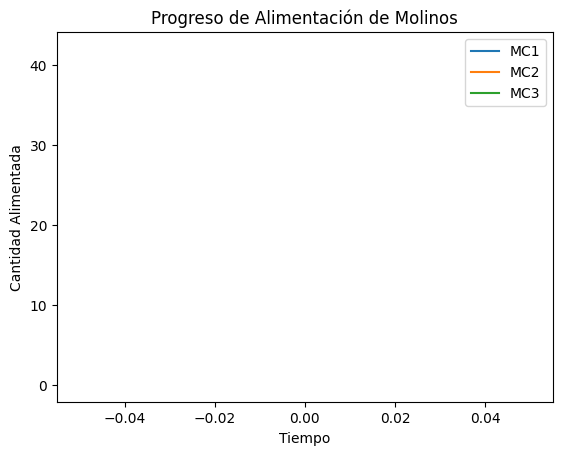

KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from threading import Lock

# # Inicializar el gráfico
# fig, ax = plt.subplots()
# ax.set_title("Progreso de Alimentación de Molinos")
# ax.set_xlabel("Tiempo")
# ax.set_ylabel("Cantidad Alimentada")

# # Listas para almacenar los datos de alimentación en el tiempo
# tiempos = []
# cantidades_MC1 = []
# cantidades_MC2 = []
# cantidades_MC3 = []

# lock = Lock()

# # Función para actualizar el gráfico durante la alimentación
# def actualizar_grafico(tiempo, cantidad_mc1, cantidad_mc2, cantidad_mc3):
#     tiempos.append(tiempo)
#     cantidades_MC1.append(cantidad_mc1)
#     cantidades_MC2.append(cantidad_mc2)
#     cantidades_MC3.append(cantidad_mc3)

#     # Limpiar el gráfico anterior
#     ax.clear()

#     # Redibujar el gráfico
#     ax.plot(tiempos, cantidades_MC1, label="MC1")
#     ax.plot(tiempos, cantidades_MC2, label="MC2")
#     ax.plot(tiempos, cantidades_MC3, label="MC3")

#     ax.set_title("Progreso de Alimentación de Molinos")
#     ax.set_xlabel("Tiempo")
#     ax.set_ylabel("Cantidad Alimentada")
#     ax.legend()

#     plt.pause(0.1)  # Pequeña pausa para que el gráfico se actualice en tiempo real

# # Simulación del proceso de alimentación
# def alimentar_molino(molino, cantidad, tiempo):
#     lock.acquire()
#     try:
#         for t in range(tiempo):  # Simulación de alimentación en 'tiempo' pasos
#             if molino == "MC1":
#                 cantidad_alimentada_mc1 = np.random.randint(0, cantidad)
#                 actualizar_grafico(t, cantidad_alimentada_mc1, 0, 0)
#             elif molino == "MC2":
#                 cantidad_alimentada_mc2 = np.random.randint(0, cantidad)
#                 actualizar_grafico(t, 0, cantidad_alimentada_mc2, 0)
#             elif molino == "MC3":
#                 cantidad_alimentada_mc3 = np.random.randint(0, cantidad)
#                 actualizar_grafico(t, 0, 0, cantidad_alimentada_mc3)
#     finally:
#         lock.release()

# # Ejemplo de uso (alimentar cada molino con una cantidad aleatoria)
# alimentar_molino("MC1", 100, 50)
# alimentar_molino("MC2", 100, 50)
# alimentar_molino("MC3", 100, 50)


In [ ]:
# ########## REVISION CALCULOS

# import random
# import time
# import threading
# import sys
# import threading
# from queue import Queue

# def redondear_diccionario(d, decimales=2):
#     return {k: round(v, decimales) if isinstance(v, (int, float)) else v for k, v in d.items()}

# # Variables globales
# tipos_produccion_actual = {
#     "MC1": None,
#     "MC2": None,
#     "MC3": None
# }

# # Cola global para materiales pendientes de alimentación
# cola_alimentacion = Queue()

# # Definición de capacidades de tolvas y niveles iniciales
# tolvas_MC1 = {
#     "Clinker": {"capacidad": 500, "max_metros": 14},
#     "Puzolana": {"capacidad": 300, "max_metros": 12},
#     "Yeso": {"capacidad": 300, "max_metros": 10}
# }
# tolvas_MC2 = {
#     "Clinker": {"capacidad": 300, "max_metros": 9},
#     "Puzolana_Humeda": {"capacidad": 500, "max_metros": 15, "tolva": "426HO04"},
#     "Puzolana_Seca": {"capacidad": 100, "max_metros": 12, "tolva": "426HO02"},
#     "Yeso": {"capacidad": 120, "max_metros": 9}
# }
# tolvas_MC3 = {
#     "Clinker": {"capacidad": 60, "max_porcentaje": 100},
#     "Clinker_Silo_Blanco": {"capacidad": 500, "max_metros": 10.5},
#     "Puzolana": {"capacidad": 35, "max_porcentaje": 100},
#     "Yeso": {"capacidad": 30, "max_porcentaje": 100}
# }

# # Se debe cambiar tipo de niveles a metros

# niveles_MC1_mtrs = {"Clinker": 8, "Puzolana": 4, "Yeso": 1}
# niveles_MC2_mtrs = {"Clinker": 9, "Puzolana_Humeda": 2, "Puzolana_Seca": 1, "Yeso": 2}
# niveles_MC3_porcentaje = {"Clinker": 40, "Clinker_Silo_Blanco": 3, "Puzolana": 10, "Yeso": 2}



# # Variables globales para rastrear alimentaciones y temporizadores
# alimentaciones_actuales = set()
# alimentaciones_en_progreso = {}
# temporizadores_molinos = {}
# lock = threading.Lock()
# lock_print = threading.Lock()


# # Modifica el bloque principal para que obtenga y guarde el tipo de producción de cada molino
# for molino in ["MC1", "MC2", "MC3"]:
#     if molino == "MC1":
#         tipos_validos = ["P30", "P40"]
#     elif molino == "MC2":
#         tipos_validos = ["P10", "P16", "P20", "P30"]
#     elif molino == "MC3":
#         tipos_validos = ["P30"]

#     print(f"\nOptimizando {molino}")
#     print(f"Este molino puede producir: {', '.join(tipos_validos)}")
#     tipo_produccion = input(f"Ingrese el tipo de producción para {molino} (o presione Enter para omitir): ").upper()

#     if tipo_produccion:
#         if tipo_produccion not in tipos_validos:
#             print(f"Error, Ingrese un tipo de producción válido para {molino}")
#             continue
#         tipos_produccion_actual[molino] = tipo_produccion  # Actualizar el tipo de producción actual en el diccionario
#     else:
#         print(f"No se ingresó tipo de producción para {molino}, omitiendo...")
#         continue

#     print(f"Producto ingresado para {molino}: {tipo_produccion}")

# def obtener_tipo_produccion_actual(molino):
#     """
#     Retorna el tipo de producción actual para un molino específico basado en lo que el usuario haya ingresado.
#     """
#     return tipos_produccion_actual.get(molino, None)  # Retorna el tipo de producción si está presente, o None si no se ha ingresado


# def calcular_consumo(molino, material):
#     tipo_produccion = obtener_tipo_produccion_actual(molino)
#     necesidades = calcular_necesidades(molino, tipo_produccion)
#     return necesidades.get(material, 0)

# def nivel_ineficiente_tolva(molino, material):
#     if molino == "MC1":
#         niveles = niveles_MC1_mtrs
#         tolvas = tolvas_MC1
#         return 0.2*tolvas[material]['max_metros']  # 20% de la capacidad
#     elif molino == "MC2":
#         niveles = niveles_MC2_mtrs
#         tolvas = tolvas_MC2
#         return 0.2*tolvas[material]['max_metros']  # 20% de la capacidad
#     else:  # MC3
#         niveles = niveles_MC3_porcentaje
#         tolvas = tolvas_MC3
#         return 0.5*tolvas[material]['max_porcentaje'] # 50% de la capacidad


# # Funciones auxiliares
# def calcular_tiempo_vaciado(molino, material):
#     if molino == "MC1":
#         niveles = niveles_MC1_mtrs
#         tolvas = tolvas_MC1
#         capacidad = tolvas[material]['capacidad']
#         print(f"Capacidad de {material}: {capacidad}t")
#         nivel_actual = niveles[material]
#         print(f"Nivel actual de {material}: {nivel_actual}t")
#         nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
#         print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}t")

#     elif molino == "MC2":
#         niveles = niveles_MC2_mtrs
#         tolvas = tolvas_MC2
#         capacidad = tolvas[material]['capacidad']
#         print(f"Capacidad de {material}: {capacidad}t")
#         nivel_actual = niveles[material]
#         print(f"Nivel actual de {material}: {nivel_actual}t")
#         nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
#         print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}t")

#     else:  # MC3
#         niveles = niveles_MC3_porcentaje
#         tolvas = tolvas_MC3
#         capacidad = tolvas[material]['capacidad']
#         print(f"Capacidad de {material}: {capacidad}t")
#         nivel_actual = niveles[material]
#         print(f"Nivel actual de {material}: {nivel_actual}%")
#         nivel_ineficiente = nivel_ineficiente_tolva(molino, material)
#         print(f"Nivel Ineficiente de {material}: {nivel_ineficiente}%")

#     if 'max_metros' in tolvas[material]:
#         max_nivel = tolvas[material]['max_metros']
#         toneladas_reales = ((nivel_actual - nivel_ineficiente) * capacidad) / max_nivel
#         print("nivel actual", nivel_actual)
#         print("nivel ineficiente",nivel_ineficiente)
#         print("capacidad",capacidad)
#         print("max nivel",max_nivel)
#         print("toneladas reales",toneladas_reales)
#     else:  # Para MC3 que usa porcentajes
#         toneladas_reales = ((nivel_actual - nivel_ineficiente) * capacidad) /100
#         print("toneladas reales",toneladas_reales)
#     consumo = calcular_consumo(molino, material)
#     print(f"Consumo de {material}: {consumo}t/h")

#     if consumo > 0:
#         return toneladas_reales / consumo
#     else:
#         return float('inf')




# def calcular_necesidades(molino, tipo_produccion):
#     produccion_MC1 = {
#         "P30": (0.30, 0.015, 75),  #72
#         "P40": (0.40, 0.015, 65)
#     }
#     produccion_MC2 = {
#         "P10": (0.10, 0.03, 65),
#         "P16": (0.16, 0.025, 80),
#         "P20": (0.12, 0.025, 90),
#         "P30": (0.30, 0.02, 110)
#     }
#     produccion_MC3 = {
#         "P30": (0.30, 0.025, 36)
#     }


#     if molino == "MC1" and tipo_produccion in produccion_MC1:
#         puzolana, yeso, produccion = produccion_MC1[tipo_produccion]
#         clinker = 1 - puzolana - yeso
#         return {
#             "Clinker": clinker * produccion,
#             "Puzolana": puzolana * produccion,
#             "Yeso": yeso * produccion
#         }
#     elif molino == "MC2" and tipo_produccion in produccion_MC2:
#         puzolana, yeso, produccion = produccion_MC2[tipo_produccion]
#         clinker = 1 - puzolana - yeso
#         return {
#             "Clinker": clinker * produccion,
#             "Puzolana_Humeda": puzolana * produccion,
#             "Puzolana_Seca": puzolana * produccion,
#             "Yeso": yeso * produccion
#         }
#     elif molino == "MC3" and tipo_produccion in produccion_MC3:
#         puzolana, yeso, produccion = produccion_MC3[tipo_produccion]
#         clinker = 1 - puzolana - yeso
#         return {
#             "Clinker": clinker * produccion,
#             "Puzolana": puzolana * produccion,
#             "Yeso": yeso * produccion
#         }


#     print(f"Advertencia: No se encontró configuración para {molino} con producto {tipo_produccion}")
#     return {"Clinker": 60, "Puzolana": 30, "Yeso": 10}

# tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Clinker")
# print("Tv L1 CL",tiempo_vaciado_L1)
# print("")
# tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Clinker")
# print("Tv L2 CL",tiempo_vaciado_L2)
# print("")
# tiempo_vaciado_L3 = calcular_tiempo_vaciado("MC3", "Clinker")
# print("Tv L3 CL",tiempo_vaciado_L3)
# print("")
# tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Puzolana")
# print("Tv L1 Pz",tiempo_vaciado_L1)
# print("")
# tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Humeda")
# print("Tv L2 Pz",tiempo_vaciado_L2)
# print("")
# tiempo_vaciado_PS_L2 = calcular_tiempo_vaciado("MC2", "Puzolana_Seca")
# print("Tv L2 PS",tiempo_vaciado_PS_L2)
# print("")
# tiempo_vaciado_PS_L3 = calcular_tiempo_vaciado("MC3", "Puzolana")
# print("Tv L3 Pz",tiempo_vaciado_PS_L3)
# print("")
# tiempo_vaciado_L1 = calcular_tiempo_vaciado("MC1", "Yeso")
# print("Tv L1 Yeso",tiempo_vaciado_L1)
# print("")
# tiempo_vaciado_L2 = calcular_tiempo_vaciado("MC2", "Yeso")
# print("Tv L2 Yeso",tiempo_vaciado_L2)
# print("")
# tiempo_vaciado_L3 = calcular_tiempo_vaciado("MC3", "Yeso")
# print("Tv L3 Yeso",tiempo_vaciado_L3)

# def nivel_silo_blanco():
#     return niveles_MC3_porcentaje["Clinker_Silo_Blanco"] / tolvas_MC3["Clinker_Silo_Blanco"]["capacidad"] * tolvas_MC3["Clinker_Silo_Blanco"]["max_metros"]
# print("nivel_silo_blanco",nivel_silo_blanco())


Optimizando MC1
Este molino puede producir: P30, P40
Ingrese el tipo de producción para MC1 (o presione Enter para omitir): P30
Producto ingresado para MC1: P30

Optimizando MC2
Este molino puede producir: P10, P16, P20, P30
Ingrese el tipo de producción para MC2 (o presione Enter para omitir): P10
Producto ingresado para MC2: P10

Optimizando MC3
Este molino puede producir: P30
Ingrese el tipo de producción para MC3 (o presione Enter para omitir): P30
Producto ingresado para MC3: P30
Capacidad de Clinker: 500t
Nivel actual de Clinker: 8t
Nivel Ineficiente de Clinker: 2.8000000000000003t
nivel actual 8
nivel ineficiente 2.8000000000000003
capacidad 500
max nivel 14
toneladas reales 185.7142857142857
Consumo de Clinker: 51.37499999999999t/h
Tv L1 CL 3.6148766075773375

Capacidad de Clinker: 300t
Nivel actual de Clinker: 9t
Nivel Ineficiente de Clinker: 1.8t
nivel actual 9
nivel ineficiente 1.8
capacidad 300
max nivel 9
toneladas reales 240.0
Consumo de Clinker: 56.55t/h
Tv L2 CL 4.2440

In [ ]:
# # Función para convertir de metros a toneladas
# def metros_a_toneladas(niveles, tolvas):
#     toneladas = {}
#     for material, metros in niveles.items():
#         # Verificamos si usamos metros o porcentaje
#         if "max_metros" in tolvas[material]:
#             capacidad = tolvas[material]["capacidad"]
#             max_metros = tolvas[material]["max_metros"]
#             toneladas[material] = round((metros * capacidad) / max_metros, 2)
#         elif "max_porcentaje" in tolvas[material]:
#             capacidad = tolvas[material]["capacidad"]
#             toneladas[material] = round((metros * capacidad) / 100, 2)
#     return toneladas

# # Niveles ingresados por el operador
# niveles_MC1 = {"Clinker": 8, "Puzolana": 4, "Yeso": 1}
# niveles_MC2 = {"Clinker": 9, "Puzolana_Humeda": 2, "Puzolana_Seca": 1, "Yeso": 2}
# niveles_MC3 = {"Clinker": 40, "Clinker_Silo_Blanco": 3, "Puzolana": 10, "Yeso": 2}

# # Definición de capacidades de tolvas y niveles
# tolvas_MC1 = {
#     "Clinker": {"capacidad": 500, "max_metros": 14},
#     "Puzolana": {"capacidad": 300, "max_metros": 12},
#     "Yeso": {"capacidad": 300, "max_metros": 10}
# }

# tolvas_MC2 = {
#     "Clinker": {"capacidad": 300, "max_metros": 9},
#     "Puzolana_Humeda": {"capacidad": 500, "max_metros": 15, "tolva": "426HO04"},
#     "Puzolana_Seca": {"capacidad": 100, "max_metros": 12, "tolva": "426HO02"},
#     "Yeso": {"capacidad": 120, "max_metros": 9}
# }

# tolvas_MC3 = {
#     "Clinker": {"capacidad": 60, "max_porcentaje": 100},
#     "Clinker_Silo_Blanco": {"capacidad": 500, "max_metros": 10.5},
#     "Puzolana": {"capacidad": 35, "max_porcentaje": 100},
#     "Yeso": {"capacidad": 30, "max_porcentaje": 100}
# }

# # Convertimos los niveles de metros a toneladas
# niveles_MC1_toneladas = metros_a_toneladas(niveles_MC1, tolvas_MC1)
# niveles_MC2_toneladas = metros_a_toneladas(niveles_MC2, tolvas_MC2)
# niveles_MC3_toneladas = metros_a_toneladas(niveles_MC3, tolvas_MC3)

# # niveles_MC1_toneladas = niveles_MC1
# # niveles_MC2_toneladas = niveles_MC2
# # niveles_MC3_toneladas = niveles_MC3


# # Imprimir los resultados en el mismo formato solicitado
# print(f"niveles_MC1_toneladas = {niveles_MC1_toneladas}")
# print(f"niveles_MC2_toneladas = {niveles_MC2_toneladas}")
# print(f"niveles_MC3_toneladas = {niveles_MC3_toneladas}")

# # # Imprimir los resultados en el mismo formato solicitado
# print("clinker MC1",niveles_MC1_toneladas["Clinker"])
# # print(f"niveles_MC2= {niveles_MC2}")
# # print(f"niveles_MC3 = {niveles_MC3}")



niveles_MC1_toneladas = {'Clinker': 285.71, 'Puzolana': 100.0, 'Yeso': 30.0}
niveles_MC2_toneladas = {'Clinker': 300.0, 'Puzolana_Humeda': 66.67, 'Puzolana_Seca': 8.33, 'Yeso': 26.67}
niveles_MC3_toneladas = {'Clinker': 24.0, 'Clinker_Silo_Blanco': 142.86, 'Puzolana': 3.5, 'Yeso': 0.6}
clinker MC1 285.71
